# Prep

In [3]:
!pip install ftfy regex tqdm
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [6]:
import os
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# 设置设备
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
from torch.utils.data import Dataset, DataLoader

# CLIP

## Model Prep

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-13axwwc2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-13axwwc2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=16f2f8a0710606f779076bfa4ded64dcaec80080227c9f0b197d30d2219e8ebf
  Stored in directory: /tmp/pip-ephem-wheel-cache-r335_dm8/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
import clip
from torch.cuda.amp import autocast, GradScaler

In [ ]:
# 加载模型
model, preprocess = clip.load('ViT-B/32', device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 77.1MiB/s]


## CIFA-10 Prep (8:1:1)

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
import clip
from torch.amp import autocast, GradScaler

# 初始化设备
device = "cuda" if torch.cuda.is_available() else "cpu"

def initialization():
    # 修改预处理步骤，使用CLIP推荐的预处理
    preprocess = transforms.Compose([
        transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                           (0.26862954, 0.26130258, 0.27577711))
    ])

    batch_size = 16  # 减小批量大小

    # 加载数据集
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=preprocess)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=preprocess)

    # 合并训练集和测试集
    full_dataset = torch.utils.data.ConcatDataset([trainset, testset])

    # 划分数据集
    train_size = int(0.8 * len(full_dataset))
    test_size = int(0.1 * len(full_dataset))

    train_indices, temp_indices = train_test_split(
        list(range(len(full_dataset))), train_size=train_size, random_state=42)
    test_indices, zero_shot_indices = train_test_split(
        temp_indices, test_size=0.5, random_state=42)

    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    test_dataset = torch.utils.data.Subset(full_dataset, test_indices)
    zero_shot_dataset = torch.utils.data.Subset(full_dataset, zero_shot_indices)

    trainloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    zero_shot_loader = torch.utils.data.DataLoader(
        zero_shot_dataset, batch_size=1, shuffle=True)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, zero_shot_loader, classes


In [ ]:
for images, _ in trainloader:
    print(f"Input image min: {images.min()}, max: {images.max()}")
    break

Input image min: -1.0, max: 1.0


## Model Training

In [ ]:
import torch

# 清理CUDA缓存
torch.cuda.empty_cache()

print("CUDA cache cleared.")

CUDA cache cleared.


In [ ]:
# 初始化CLIP模型
model, _ = clip.load("ViT-B/32", device=device, jit=False)  # 禁用JIT以提高稳定性
model = model.float()  # 确保模型使用float32

# 冻结部分层来提高训练稳定性
for param in model.parameters():
    param.requires_grad = False
for param in model.visual.transformer.resblocks[-2:].parameters():
    param.requires_grad = True

trainloader, testloader, zero_shot_loader, classes = initialization()

# 修改优化器和学习率
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-6,  # 降低学习率
    weight_decay=0.1,  # 添加权重衰减
    eps=1e-8  # 提高数值稳定性
)

criterion = nn.CrossEntropyLoss()
scaler = GradScaler('cuda')

# 学习率调度器
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def normalize_features(features):
    return features / features.norm(dim=-1, keepdim=True)

In [ ]:
print(f"Image Features range: {image_features.min()}, {image_features.max()}")
print(f"Text Features range: {text_features.min()}, {text_features.max()}")

Image Features range: nan, nan
Text Features range: nan, nan


In [ ]:
# 训练模型
num_epochs = 10  # 减少轮数

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    valid_batches = 0

    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        try:
            with autocast('cuda'):
                # 获取特征
                image_features = model.encode_image(images)
                text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)
                text_features = model.encode_text(text_inputs)

                # 检查是否有无效值
                if torch.isnan(image_features).any() or torch.isnan(text_features).any():
                    print(f"Skipping batch {batch_idx} due to NaN values")
                    continue

                # 特征归一化
                image_features = normalize_features(image_features)
                text_features = normalize_features(text_features)

                # 计算相似度和损失
                logits = image_features @ text_features.T * 100.0
                loss = criterion(logits, labels)

            # 梯度缩放和反向传播
            scaler.scale(loss).backward()

            # 梯度裁剪
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            valid_batches += 1

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}')

        except RuntimeError as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue

    # 更新学习率
    scheduler.step()

    # 计算平均损失
    if valid_batches > 0:
        epoch_loss = running_loss / valid_batches
        print(f'Epoch {epoch+1} completed. Average loss: {epoch_loss:.4f}')

    # 评估模式
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            try:
                image_features = model.encode_image(images)
                text_features = model.encode_text(text_inputs)

                image_features = normalize_features(image_features)
                text_features = normalize_features(text_features)

                logits = image_features @ text_features.T * 100.0
                loss = criterion(logits, labels)

                test_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            except RuntimeError as e:
                print(f"Error in test batch: {str(e)}")
                continue

    if total > 0:
        accuracy = 100. * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')

    # 保存检查点
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, f'checkpoint_epoch_{epoch+1}.pt')

    torch.cuda.empty_cache()

Epoch: 1, Batch: 0, Loss: 0.3157
Epoch: 1, Batch: 10, Loss: 0.7105
Epoch: 1, Batch: 20, Loss: 0.5281
Epoch: 1, Batch: 30, Loss: 0.1808
Epoch: 1, Batch: 40, Loss: 0.2802
Epoch: 1, Batch: 50, Loss: 0.1784
Epoch: 1, Batch: 60, Loss: 0.3360
Epoch: 1, Batch: 70, Loss: 0.0273
Epoch: 1, Batch: 80, Loss: 0.5040
Epoch: 1, Batch: 90, Loss: 0.0988
Epoch: 1, Batch: 100, Loss: 0.2466
Epoch: 1, Batch: 110, Loss: 0.2020
Epoch: 1, Batch: 120, Loss: 0.0439
Epoch: 1, Batch: 130, Loss: 0.1812
Epoch: 1, Batch: 140, Loss: 0.0672
Epoch: 1, Batch: 150, Loss: 0.2109
Epoch: 1, Batch: 160, Loss: 0.2875
Epoch: 1, Batch: 170, Loss: 0.3347
Epoch: 1, Batch: 180, Loss: 0.3371
Epoch: 1, Batch: 190, Loss: 0.0934
Epoch: 1, Batch: 200, Loss: 0.1682
Epoch: 1, Batch: 210, Loss: 0.1002
Epoch: 1, Batch: 220, Loss: 0.2432
Epoch: 1, Batch: 230, Loss: 0.4589
Epoch: 1, Batch: 240, Loss: 0.1166
Epoch: 1, Batch: 250, Loss: 0.2617
Epoch: 1, Batch: 260, Loss: 0.0983
Epoch: 1, Batch: 270, Loss: 0.3763
Epoch: 1, Batch: 280, Loss: 0.1

In [ ]:
#  保存训练好的模型
save_path = "/content/drive/MyDrive/trained_clip_model.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, save_path)

In [ ]:
# 下次加载模型

model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
checkpoint = torch.load("/content/drive/MyDrive/trained_clip_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

## Plot

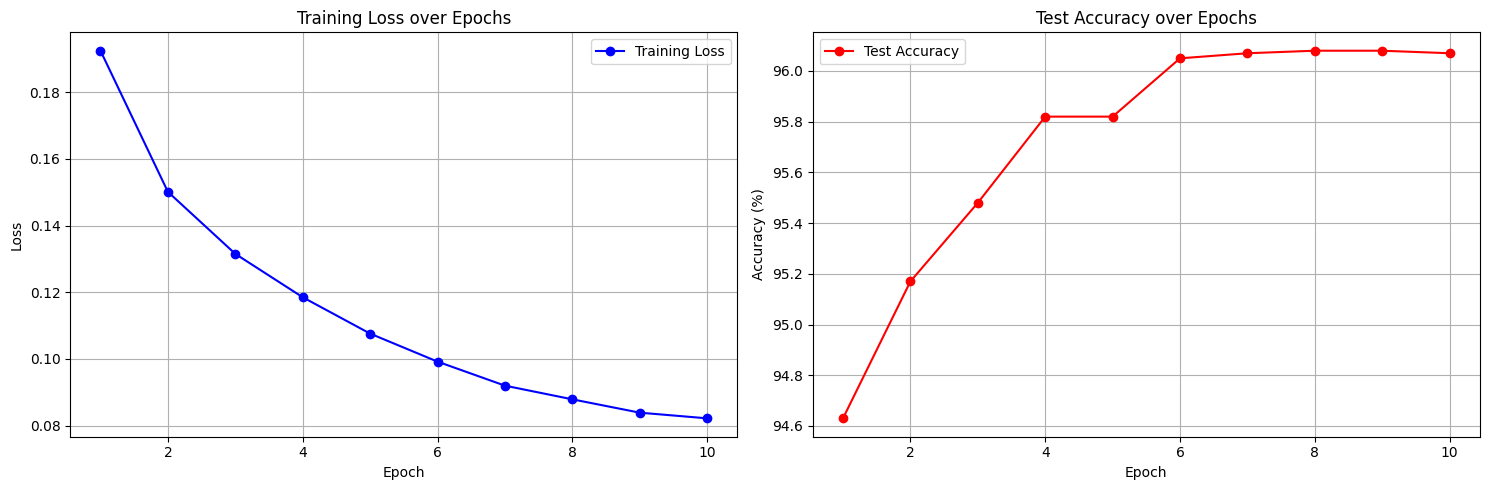

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 从你的输出中提取数据
training_losses = [0.1924, 0.1501, 0.1315, 0.1185, 0.1076, 0.0992, 0.0920, 0.0879, 0.0839, 0.0822]
test_accuracies = [94.63, 95.17, 95.48, 95.82, 95.82, 96.05, 96.07, 96.08, 96.08, 96.07]
epochs = range(1, len(training_losses) + 1)

# 创建图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 绘制训练损失
ax1.plot(epochs, training_losses, 'b-o', label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Epochs')
ax1.grid(True)
ax1.legend()

# 绘制测试准确率
ax2.plot(epochs, test_accuracies, 'r-o', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy over Epochs')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# 保存图片到Google Drive
plt.savefig('/content/drive/MyDrive/training_plots.png')

## Test in CIFA

In [ ]:
def test_accuracy_on_cifar():
    # 首先获取数据加载器和类别
    trainloader, testloader, zero_shot_loader, classes = initialization()

    # 加载训练好的模型
    model, _ = clip.load("ViT-B/32", device=device, jit=False)
    checkpoint = torch.load('/content/drive/MyDrive/trained_clip_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()
    correct = 0
    total = 0

    # 准备文本特征
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            # 获取图像和文本特征
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_inputs)

            # 归一化特征
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # 计算相似度和预测
            similarity = (100.0 * image_features @ text_features.T)
            _, predicted = similarity.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 打印每个批次的准确率，用于确认代码在运行
            batch_accuracy = 100 * correct / total
            print(f'Current accuracy: {batch_accuracy:.2f}%', end='\r')

    final_accuracy = 100 * correct / total
    print(f'\nFinal accuracy on CIFAR-10 test set: {final_accuracy:.2f}%')
    return final_accuracy

# 直接调用函数进行测试
accuracy = test_accuracy_on_cifar()

Files already downloaded and verified
Files already downloaded and verified


<ipython-input-53-179310c52c9e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/trained_clip_model.pt')



Final accuracy on CIFAR-10 test set: 96.05%


## Zero-shot test in CIFA

In [ ]:
def test_zero_shot_predictions():
    # 测试几个样本
    num_samples = 10  # 你可以修改这个数字来测试更多样本

    with torch.no_grad():
        for i, (images, labels) in enumerate(zero_shot_loader):
            if i >= num_samples:
                break

            images = images.to(device)
            labels = labels.to(device)

            # 准备文本特征
            text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

            # 获取图像和文本特征
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_inputs)

            # 归一化特征
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # 计算相似度和概率
            similarity = (100.0 * image_features @ text_features.T).squeeze(0)
            probabilities = torch.nn.functional.softmax(similarity, dim=0)

            # 获取前5个最高概率的预测
            top5_prob, top5_idx = torch.topk(probabilities, 5)

            # 打印真实标签和预测结果
            print(f"\nImage {i+1}")
            print(f"True label: {classes[labels[0]]}")
            print("Top 5 predictions:")
            for idx, prob in zip(top5_idx, top5_prob):
                print(f"{classes[idx]:>10}: {prob.item():.2f}%")
            print("-" * 50)

# 直接调用函数进行测试
test_zero_shot_predictions()


Image 1
True label: deer
Top 5 predictions:
      deer: 0.99%
      bird: 0.01%
     horse: 0.00%
     plane: 0.00%
       cat: 0.00%
--------------------------------------------------

Image 2
True label: frog
Top 5 predictions:
      frog: 1.00%
      bird: 0.00%
       cat: 0.00%
       dog: 0.00%
       car: 0.00%
--------------------------------------------------

Image 3
True label: deer
Top 5 predictions:
      deer: 1.00%
     horse: 0.00%
      bird: 0.00%
       cat: 0.00%
       dog: 0.00%
--------------------------------------------------

Image 4
True label: deer
Top 5 predictions:
      deer: 1.00%
     horse: 0.00%
      bird: 0.00%
       dog: 0.00%
       cat: 0.00%
--------------------------------------------------

Image 5
True label: frog
Top 5 predictions:
      frog: 1.00%
       dog: 0.00%
      bird: 0.00%
       cat: 0.00%
      deer: 0.00%
--------------------------------------------------

Image 6
True label: cat
Top 5 predictions:
       cat: 1.00%
       d

## Cal101 prep

In [9]:
class Cal101Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = [
            'airplane', 'butterfly', 'camera', 'fan', 'chair',
            'guitar', 'pizza', 'soccerball', 'umbrella', 'wheelchair',
            'wild_cat', 'windsor_chair', 'motorbikes', 'scissor', 'watch'
        ]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []

        # 遍历所有类别文件夹
        for class_name in self.classes:
            class_path = os.path.join(root_dir, 'pic', class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(class_path, img_name)
                        self.images.append(img_path)
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
def initialize_cal101():
    # CLIP推荐的预处理
    preprocess = transforms.Compose([
        transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                           (0.26862954, 0.26130258, 0.27577711))
    ])

    # 加载数据集
    dataset = Cal101Dataset(
        root_dir='/content/drive/MyDrive/Final_NLP/dataset',
        transform=preprocess
    )

    # 划分数据集
    train_size = int(0.5 * len(dataset))  =
    test_indices, zero_shot_indices = train_test_split(
        list(range(len(dataset))), test_size=0.5, random_state=42
    )

    # 创建子集
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    zero_shot_dataset = torch.utils.data.Subset(dataset, zero_shot_indices)

    # 创建数据加载器
    batch_size = 16
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    zero_shot_loader = DataLoader(
        zero_shot_dataset, batch_size=1, shuffle=True, num_workers=2
    )

    return test_loader, zero_shot_loader, dataset.classes

## ACC and Zero-shot test on Cal101


In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import clip
import torch.nn.functional as F

In [ ]:
def test_accuracy_cal101():
    # 获取数据加载器和类别
    test_loader, _, classes = initialize_cal101()

    # 加载训练好的模型
    model, _ = clip.load("ViT-B/32", device=device, jit=False)
    checkpoint = torch.load('/content/drive/MyDrive/trained_clip_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()
    correct = 0
    total = 0

    # 准备文本特征
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 获取图像和文本特征
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_inputs)

            # 归一化特征
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # 计算相似度和预测
            similarity = (100.0 * image_features @ text_features.T)
            _, predicted = similarity.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 打印每个批次的准确率
            batch_accuracy = 100 * correct / total
            print(f'Current accuracy: {batch_accuracy:.2f}%', end='\r')

    final_accuracy = 100 * correct / total
    print(f'\nFinal accuracy on Cal101 test set: {final_accuracy:.2f}%')
    return final_accuracy

def test_zero_shot_cal101():
    # 获取数据加载器和类别
    _, zero_shot_loader, classes = initialize_cal101()

    # 加载模型
    model, _ = clip.load("ViT-B/32", device=device, jit=False)
    checkpoint = torch.load('/content/drive/MyDrive/trained_clip_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in zero_shot_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 准备文本特征
            text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

            # 获取特征
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_inputs)

            # 归一化特征
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # 计算相似度和概率
            similarity = (100.0 * image_features @ text_features.T).squeeze(0)
            probabilities = F.softmax(similarity, dim=0)

            # 计算top1和top5准确率
            top5_prob, top5_idx = torch.topk(probabilities, 5)

            total += 1
            if labels[0] == top5_idx[0]:
                correct_top1 += 1
            if labels[0] in top5_idx:
                correct_top5 += 1

            # 打印每个样本的预测结果
            print(f"\nTrue label: {classes[labels[0]]}")
            print("Top 5 predictions:")
            for idx, prob in zip(top5_idx, top5_prob):
                print(f"{classes[idx]:>15}: {prob.item():.2f}%")

    print(f"\nZero-shot Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")
    print(f"Zero-shot Top-5 Accuracy: {100 * correct_top5 / total:.2f}%")

# 运行测试
print("Testing normal accuracy:")
test_accuracy_cal101()
print("\nTesting zero-shot performance:")
test_zero_shot_cal101()

Testing normal accuracy:


<ipython-input-63-5dad41e27b29>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/trained_clip_model.pt')


Current accuracy: 96.94%
Final accuracy on Cal101 test set: 96.94%

Testing zero-shot performance:


<ipython-input-63-5dad41e27b29>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/trained_clip_model.pt')



True label: windsor_chair
Top 5 predictions:
  windsor_chair: 0.96%
          chair: 0.04%
     wheelchair: 0.00%
       wild_cat: 0.00%
            fan: 0.00%

True label: watch
Top 5 predictions:
          watch: 1.00%
            fan: 0.00%
     motorbikes: 0.00%
         camera: 0.00%
       airplane: 0.00%

True label: butterfly
Top 5 predictions:
      butterfly: 1.00%
            fan: 0.00%
         camera: 0.00%
       airplane: 0.00%
     motorbikes: 0.00%

True label: pizza
Top 5 predictions:
          pizza: 1.00%
     soccerball: 0.00%
          watch: 0.00%
            fan: 0.00%
        scissor: 0.00%

True label: wild_cat
Top 5 predictions:
       wild_cat: 1.00%
  windsor_chair: 0.00%
        scissor: 0.00%
          chair: 0.00%
          pizza: 0.00%

True label: umbrella
Top 5 predictions:
       umbrella: 0.85%
          chair: 0.06%
            fan: 0.04%
  windsor_chair: 0.03%
     wheelchair: 0.02%

True label: pizza
Top 5 predictions:
          pizza: 1.00%
   

## Plot

<ipython-input-66-43fbdff37e89>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/trained_clip_model.pt')


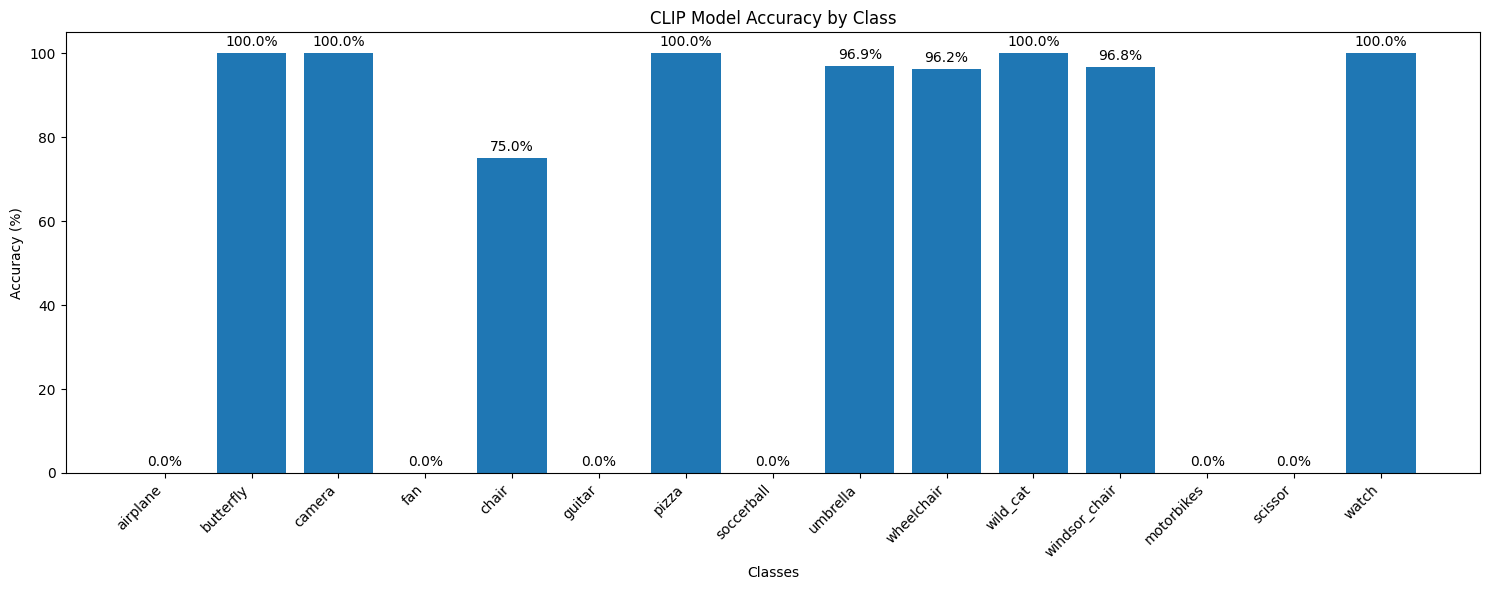

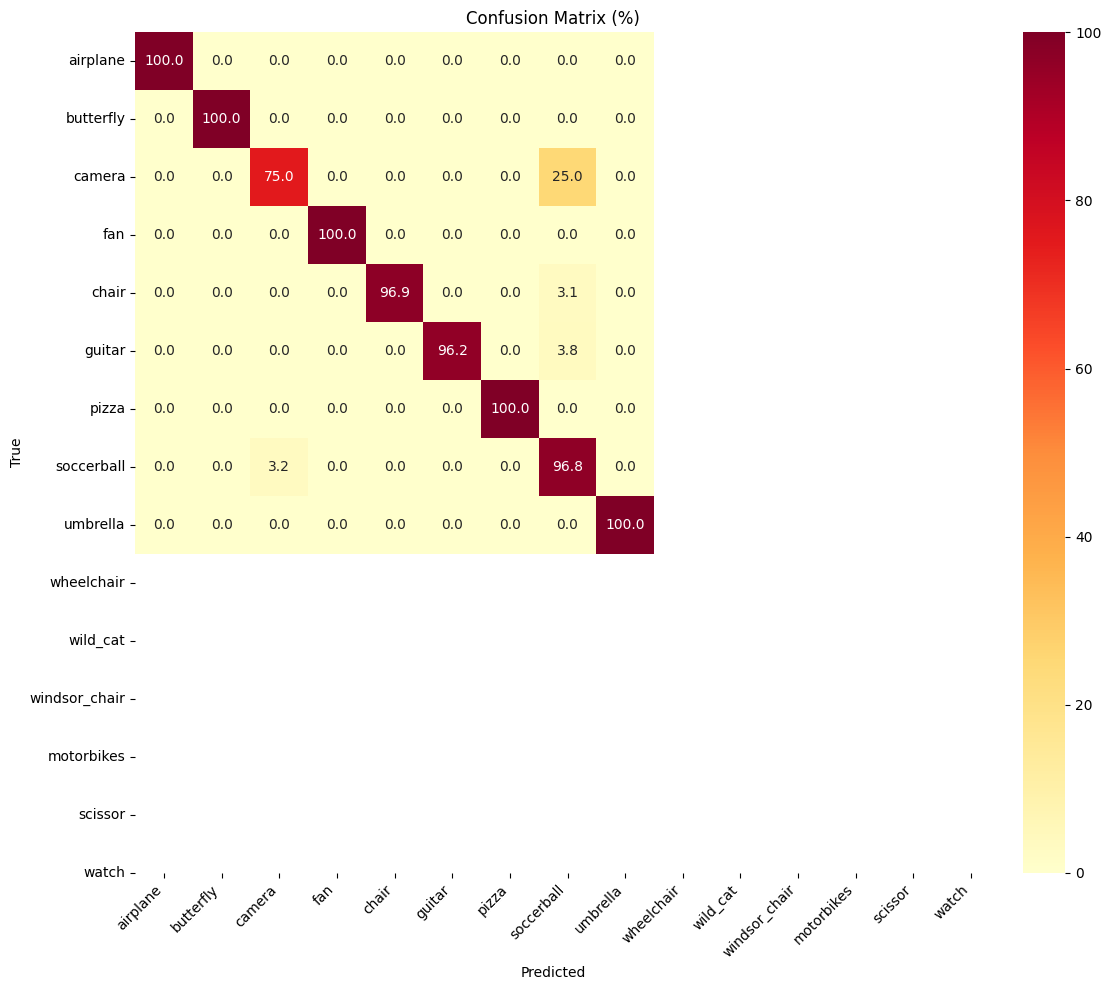


Detailed class accuracies:
airplane       : 0.00% (0/0)
butterfly      : 100.00% (37/37)
camera         : 100.00% (26/26)
fan            : 0.00% (0/0)
chair          : 75.00% (24/32)
guitar         : 0.00% (0/0)
pizza          : 100.00% (25/25)
soccerball     : 0.00% (0/0)
umbrella       : 96.88% (31/32)
wheelchair     : 96.15% (25/26)
wild_cat       : 100.00% (20/20)
windsor_chair  : 96.77% (30/31)
motorbikes     : 0.00% (0/0)
scissor        : 0.00% (0/0)
watch          : 100.00% (130/130)

Overall accuracy: 96.94%


In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import clip
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_class_accuracies():
    # 获取数据加载器和类别
    test_loader, _, classes = initialize_cal101()

    # 加载训练好的模型
    model, _ = clip.load("ViT-B/32", device=device, jit=False)
    checkpoint = torch.load('/content/drive/MyDrive/trained_clip_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # 为每个类别初始化计数器
    class_correct = {cls: 0 for cls in classes}
    class_total = {cls: 0 for cls in classes}

    # 用于混淆矩阵
    all_preds = []
    all_labels = []

    # 准备文本特征
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 获取特征
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_inputs)

            # 归一化特征
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # 计算相似度和预测
            similarity = (100.0 * image_features @ text_features.T)
            _, predicted = similarity.max(1)

            # 收集预测结果
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 更新每个类别的统计信息
            for label, pred in zip(labels, predicted):
                label_name = classes[label]
                class_total[label_name] += 1
                if label == pred:
                    class_correct[label_name] += 1

    # 计算每个类别的准确率
    class_accuracies = {cls: (class_correct[cls] / class_total[cls]) * 100
                       if class_total[cls] > 0 else 0
                       for cls in classes}

    # 绘制柱状图
    plt.figure(figsize=(15, 6))
    plt.bar(class_accuracies.keys(), class_accuracies.values())
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('CLIP Model Accuracy by Class')

    # 添加数值标签
    for i, v in enumerate(class_accuracies.values()):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # 绘制混淆矩阵
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)
    # 计算百分比
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    sns.heatmap(cm_percent, annot=True, fmt='.1f',
                xticklabels=classes,
                yticklabels=classes,
                cmap='YlOrRd')
    plt.title('Confusion Matrix (%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 打印详细的类别准确率
    print("\nDetailed class accuracies:")
    for cls in classes:
        print(f"{cls:15s}: {class_accuracies[cls]:.2f}% ({class_correct[cls]}/{class_total[cls]})")

    # 计算总体准确率
    total_correct = sum(class_correct.values())
    total_samples = sum(class_total.values())
    overall_accuracy = (total_correct / total_samples) * 100
    print(f"\nOverall accuracy: {overall_accuracy:.2f}%")

# 运行可视化
plot_class_accuracies()

## Original CLIP model ACC and Zero-shot test on Cal101

In [ ]:
# 加载模型
model, preprocess = clip.load('ViT-B/32', device)

In [ ]:
def test_accuracy_cal101():
    # 获取数据加载器和类别
    test_loader, _, classes = initialize_cal101()

    # 加载模型
    model, preprocess = clip.load('ViT-B/32', device)

    model.eval()
    correct = 0
    total = 0

    # 准备文本特征
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 获取图像和文本特征
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_inputs)

            # 归一化特征
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # 计算相似度和预测
            similarity = (100.0 * image_features @ text_features.T)
            _, predicted = similarity.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 打印每个批次的准确率
            batch_accuracy = 100 * correct / total
            print(f'Current accuracy: {batch_accuracy:.2f}%', end='\r')

    final_accuracy = 100 * correct / total
    print(f'\nFinal accuracy on Cal101 test set: {final_accuracy:.2f}%')
    return final_accuracy

def test_zero_shot_cal101():
    # 获取数据加载器和类别
    _, zero_shot_loader, classes = initialize_cal101()

    # 加载模型
    model.eval()

    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in zero_shot_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 准备文本特征
            text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

            # 获取特征
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_inputs)

            # 归一化特征
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # 计算相似度和概率
            similarity = (100.0 * image_features @ text_features.T).squeeze(0)
            probabilities = F.softmax(similarity, dim=0)

            # 计算top1和top5准确率
            top5_prob, top5_idx = torch.topk(probabilities, 5)

            total += 1
            if labels[0] == top5_idx[0]:
                correct_top1 += 1
            if labels[0] in top5_idx:
                correct_top5 += 1

            # 打印每个样本的预测结果
            print(f"\nTrue label: {classes[labels[0]]}")
            print("Top 5 predictions:")
            for idx, prob in zip(top5_idx, top5_prob):
                print(f"{classes[idx]:>15}: {prob.item():.2f}%")

    print(f"\nZero-shot Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")
    print(f"Zero-shot Top-5 Accuracy: {100 * correct_top5 / total:.2f}%")

# 运行测试
print("Testing normal accuracy:")
test_accuracy_cal101()
print("\nTesting zero-shot performance:")
test_zero_shot_cal101()

Testing normal accuracy:
Current accuracy: 94.43%
Final accuracy on Cal101 test set: 94.43%

Testing zero-shot performance:

True label: umbrella
Top 5 predictions:
       umbrella: 0.99%
            fan: 0.00%
  windsor_chair: 0.00%
     wheelchair: 0.00%
        scissor: 0.00%

True label: umbrella
Top 5 predictions:
       umbrella: 0.91%
            fan: 0.08%
  windsor_chair: 0.00%
     motorbikes: 0.00%
          chair: 0.00%

True label: pizza
Top 5 predictions:
          pizza: 1.00%
        scissor: 0.00%
       umbrella: 0.00%
      butterfly: 0.00%
     soccerball: 0.00%

True label: wheelchair
Top 5 predictions:
     wheelchair: 0.98%
  windsor_chair: 0.01%
          chair: 0.00%
         camera: 0.00%
       umbrella: 0.00%

True label: windsor_chair
Top 5 predictions:
  windsor_chair: 0.98%
          chair: 0.02%
     wheelchair: 0.00%
            fan: 0.00%
        scissor: 0.00%

True label: butterfly
Top 5 predictions:
      butterfly: 0.98%
        scissor: 0.01%
    

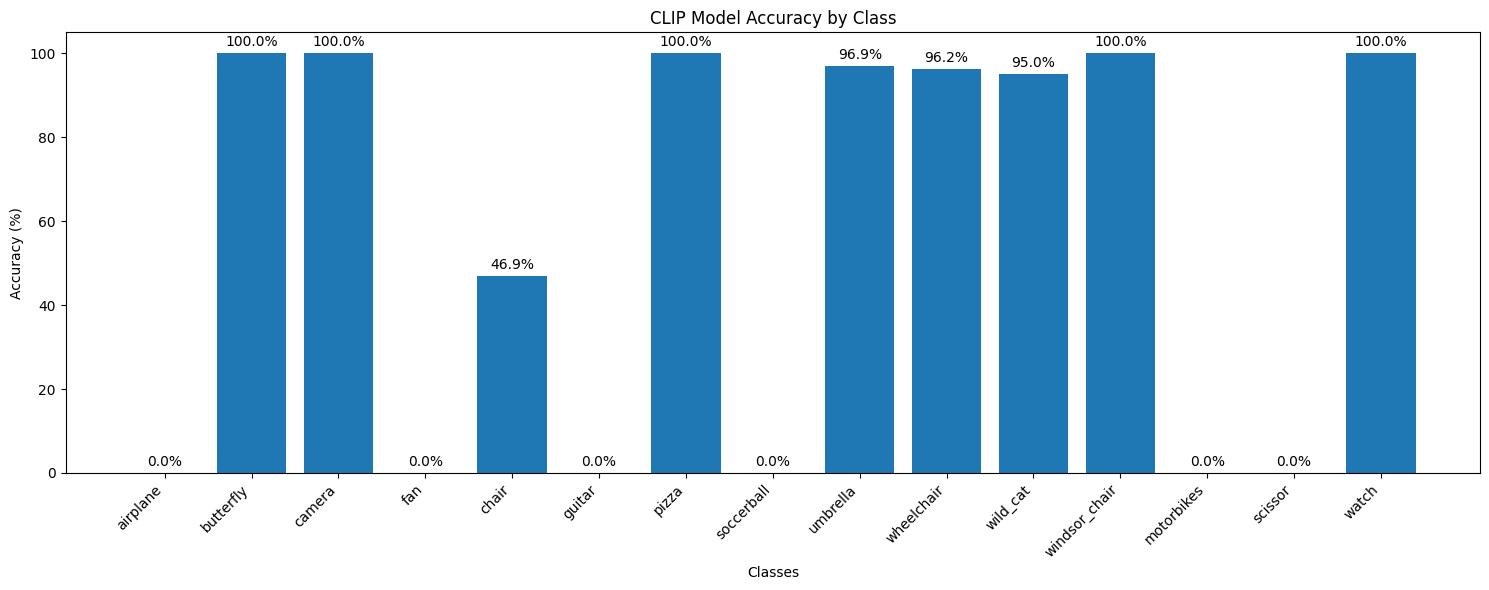

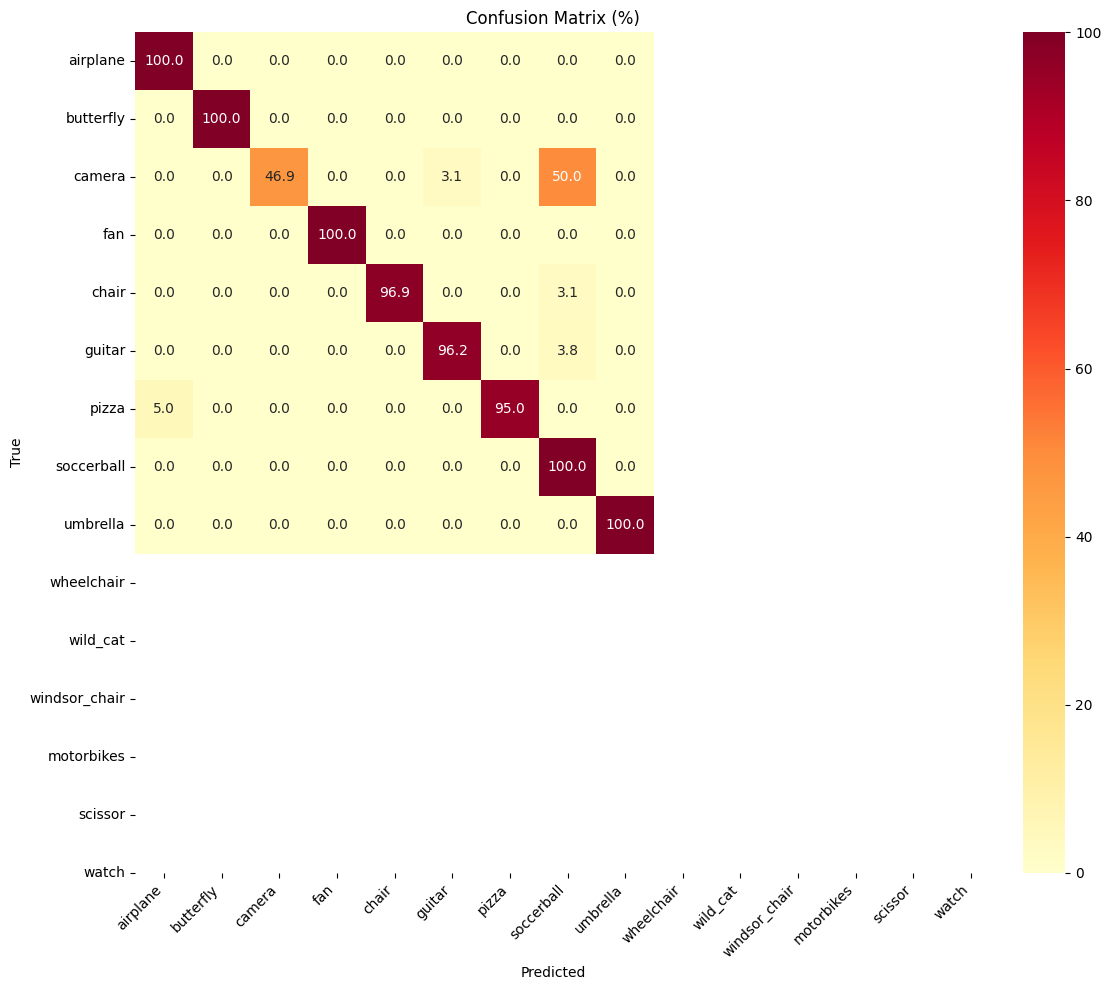


Detailed class accuracies:
airplane       : 0.00% (0/0)
butterfly      : 100.00% (37/37)
camera         : 100.00% (26/26)
fan            : 0.00% (0/0)
chair          : 46.88% (15/32)
guitar         : 0.00% (0/0)
pizza          : 100.00% (25/25)
soccerball     : 0.00% (0/0)
umbrella       : 96.88% (31/32)
wheelchair     : 96.15% (25/26)
wild_cat       : 95.00% (19/20)
windsor_chair  : 100.00% (31/31)
motorbikes     : 0.00% (0/0)
scissor        : 0.00% (0/0)
watch          : 100.00% (130/130)

Overall accuracy: 94.43%


In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import clip
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_class_accuracies():
    # 获取数据加载器和类别
    test_loader, _, classes = initialize_cal101()

    # 加载训练好的模型

    # 为每个类别初始化计数器
    class_correct = {cls: 0 for cls in classes}
    class_total = {cls: 0 for cls in classes}

    # 用于混淆矩阵
    all_preds = []
    all_labels = []

    # 准备文本特征
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 获取特征
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_inputs)

            # 归一化特征
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # 计算相似度和预测
            similarity = (100.0 * image_features @ text_features.T)
            _, predicted = similarity.max(1)

            # 收集预测结果
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 更新每个类别的统计信息
            for label, pred in zip(labels, predicted):
                label_name = classes[label]
                class_total[label_name] += 1
                if label == pred:
                    class_correct[label_name] += 1

    # 计算每个类别的准确率
    class_accuracies = {cls: (class_correct[cls] / class_total[cls]) * 100
                       if class_total[cls] > 0 else 0
                       for cls in classes}

    # 绘制柱状图
    plt.figure(figsize=(15, 6))
    plt.bar(class_accuracies.keys(), class_accuracies.values())
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('CLIP Model Accuracy by Class')

    # 添加数值标签
    for i, v in enumerate(class_accuracies.values()):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # 绘制混淆矩阵
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)
    # 计算百分比
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    sns.heatmap(cm_percent, annot=True, fmt='.1f',
                xticklabels=classes,
                yticklabels=classes,
                cmap='YlOrRd')
    plt.title('Confusion Matrix (%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 打印详细的类别准确率
    print("\nDetailed class accuracies:")
    for cls in classes:
        print(f"{cls:15s}: {class_accuracies[cls]:.2f}% ({class_correct[cls]}/{class_total[cls]})")

    # 计算总体准确率
    total_correct = sum(class_correct.values())
    total_samples = sum(class_total.values())
    overall_accuracy = (total_correct / total_samples) * 100
    print(f"\nOverall accuracy: {overall_accuracy:.2f}%")

# 运行可视化
plot_class_accuracies()

# CVCL model

## Model Prep

In [ ]:
!git clone https://github.com/wkvong/multimodal-baby.git
!pip install -r "/content/multimodal-baby/requirements.txt"

fatal: destination path 'multimodal-baby' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 55.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6988 sha256=b4983cd7e44708560a27564d6f2b6030b9a28d8e4e364cce11d1e04d2c239e16
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip


In [ ]:
!pip install huggingface_hub
!pip install pytorch-lightning==2.0.9
!pip install clip
!pip install -e /content/multimodal-baby

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.4.0
    Uninstalling pytorch-lightning-2.4.0:
      Successfully uninstalled pytorch-lightning-2.4.0
Obtaining file:///content/multimodal-baby
  Preparing metadata (setup.py) ... done
  Attempting uninstall: multimodal
    Found existing installation: multimodal 0.0.0
    Uninstalling multimodal-0.0.0:
      Successfully uninstalled multimodal-0.0.0
  Running setup.py develop for multimodal


In [ ]:
import os
import sys
import torch
import clip
from PIL import Image

In [ ]:
# 添加项目路径
project_path = "/content/multimodal-baby"
sys.path.append(project_path)

from multimodal.multimodal_lit import MultiModalLitModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

try:
    cvcl, preprocess = MultiModalLitModel.load_model(model_name="cvcl")
    cvcl = cvcl.to(device)
    cvcl.eval()
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {str(e)}")
    print("Detailed error info:", e.__class__.__name__)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


cvcl_s_dino_resnext50_embedding.ckpt:   0%|          | 0.00/120M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=map_locati

Model loaded successfully


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.
  rank_zero_warn(


## Cal101 Prep for CVCL


In [ ]:
import numpy as np
import pickle
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# 创建自定义数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.all_data = []
        self.all_labels = []
        self.transform = transform

        # 读取训练批次
        for i in range(1, 6):
            batch_path = f"{data_path}/data_batch_{i}"
            batch_dict = unpickle(batch_path)
            self.all_data.append(batch_dict[b'data'])
            self.all_labels.extend(batch_dict[b'labels'])

        self.all_data = np.vstack(self.all_data).reshape(-1, 3, 32, 32)
        self.all_data = self.all_data.transpose(0, 2, 3, 1)  # 转换为(N, 32, 32, 3)格式

    def __len__(self):
        return len(self.all_labels)

    def __getitem__(self, idx):
        img = self.all_data[idx]
        label = self.all_labels[idx]

        # 转换为PIL Image
        img = Image.fromarray(img)

        # 应用变换
        if self.transform:
            img = self.transform(img)

        return img, label

# 设置数据变换
transform = transforms.Compose([
    transforms.Resize(224),  # CVCL需要224x224的输入
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# 创建数据集和数据加载器
cifar_dataset = CIFAR10Dataset(
    data_path="/content/drive/MyDrive/Final_NLP/cifar-10-batches-py",
    transform=transform
)

# 计算分割大小
total_size = len(cifar_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# 分割数据集
train_dataset, val_dataset, test_dataset = random_split(
    cifar_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# 创建数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

## Model Training

In [16]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 直接使用forward方法
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 打印训练进度
        if (batch_idx + 1) % 100 == 0:
            print(f'Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    return total_loss / len(train_loader)

# 添加分类头到CVCL模型
class CVCLWithClassifier(torch.nn.Module):
    def __init__(self, cvcl_model):
        super().__init__()
        self.cvcl = cvcl_model
        self.classifier = torch.nn.Linear(512, 10)  # CIFAR-10有10个类别

    def encode_image(self, x):
        return self.cvcl.encode_image(x)

    def forward(self, x):
        features = self.encode_image(x)
        return self.classifier(features)


# 添加验证函数
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    avg_loss = total_loss / len(val_loader)

    return avg_loss, accuracy

In [ ]:
model = CVCLWithClassifier(cvcl).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

# 训练循环
num_epochs = 10
best_val_acc = 0
best_model = None

for epoch in range(num_epochs):
    # 训练阶段
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # 验证阶段
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # 更新学习率
    scheduler.step(val_loss)

    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%')
    print('-' * 50)

# 保存最佳模型
torch.save(best_model, 'best_model.pth')
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')

Batch [100/1250], Loss: 2.1472
Batch [200/1250], Loss: 2.0750
Batch [300/1250], Loss: 1.9933
Batch [400/1250], Loss: 1.9388
Batch [500/1250], Loss: 1.8373
Batch [600/1250], Loss: 1.7845
Batch [700/1250], Loss: 1.7226
Batch [800/1250], Loss: 1.7106
Batch [900/1250], Loss: 1.5767
Batch [1000/1250], Loss: 1.7067
Batch [1100/1250], Loss: 1.5331
Batch [1200/1250], Loss: 1.4934
Epoch [1/10]
Training Loss: 1.7987
Validation Loss: 1.4567, Accuracy: 63.00%
--------------------------------------------------
Batch [100/1250], Loss: 1.4747
Batch [200/1250], Loss: 1.3839
Batch [300/1250], Loss: 1.4429
Batch [400/1250], Loss: 1.3210
Batch [500/1250], Loss: 1.3721
Batch [600/1250], Loss: 1.3137
Batch [700/1250], Loss: 1.2741
Batch [800/1250], Loss: 1.3616
Batch [900/1250], Loss: 1.1645
Batch [1000/1250], Loss: 1.2584
Batch [1100/1250], Loss: 1.2689
Batch [1200/1250], Loss: 1.1231
Epoch [2/10]
Training Loss: 1.3218
Validation Loss: 1.1558, Accuracy: 67.06%
---------------------------------------------

## Plot

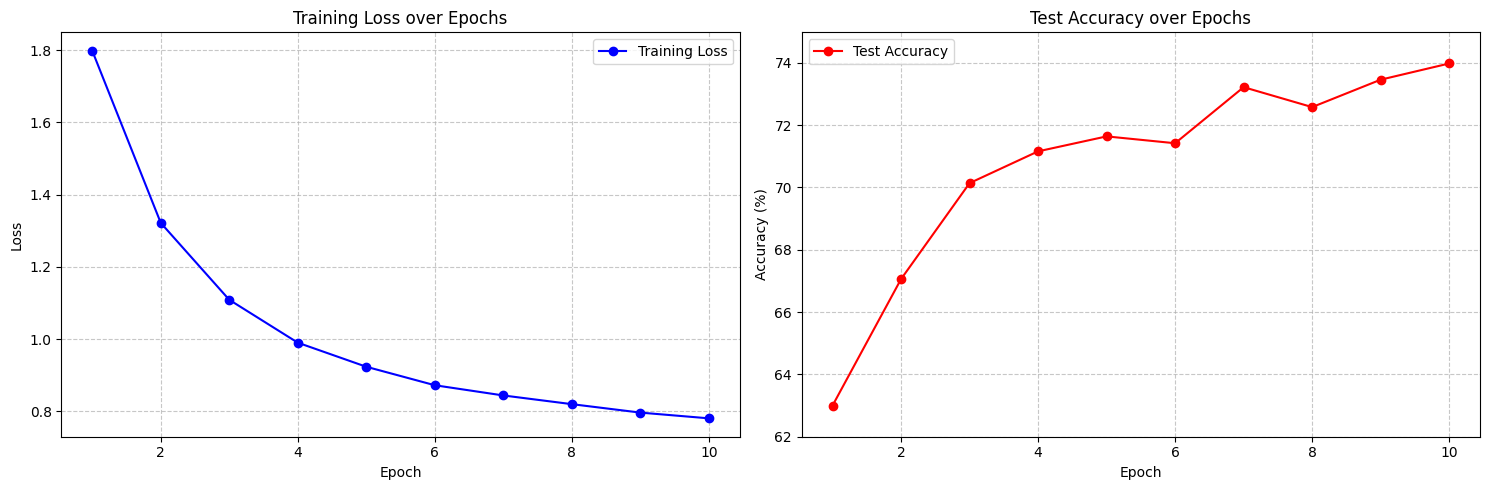

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 从你的输出中提取数据
training_losses = [1.7987, 1.3218, 1.1087, 0.9899, 0.9232, 0.8720, 0.8437, 0.8196, 0.7962, 0.7803]
validation_accuracies = [63.00, 67.06, 70.14, 71.16, 71.64, 71.42, 73.22, 72.58, 73.46, 73.98]
epochs = range(1, len(training_losses) + 1)

# 创建图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 绘制训练损失
ax1.plot(epochs, training_losses, 'b-o', label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Epochs')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# 绘制验证准确率
ax2.plot(epochs, validation_accuracies, 'r-o', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy over Epochs')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# 设置y轴的范围，使图像更清晰
min_acc = min(validation_accuracies) - 1
max_acc = max(validation_accuracies) + 1
ax2.set_ylim(min_acc, max_acc)

# 使网格在数据后面
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

plt.tight_layout()
plt.show()

# 保存图片到Google Drive
plt.savefig('/content/drive/MyDrive/training_plots.png', dpi=300, bbox_inches='tight')

In [ ]:
# 保存模型
save_path = "/content/drive/MyDrive/trained_cvcl_model.pt"  # 可以修改保存路径
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/trained_cvcl_model.pt


## Test in CIFA

In [ ]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pickle

# 定义读取CIFAR数据的函数
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# 定义测试数据集类
class CIFAR10TestDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform

        # 只读取测试批次
        test_batch_path = f"{data_path}/test_batch"
        test_dict = unpickle(test_batch_path)
        self.data = test_dict[b'data']
        self.labels = test_dict[b'labels']

        self.data = self.data.reshape(-1, 3, 32, 32)
        self.data = self.data.transpose(0, 2, 3, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, label

# 定义测试函数
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    class_correct = [0] * 10
    class_total = [0] * 10

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # 计算每个类别的准确率
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # 计算总体准确率
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(test_loader)

    # 打印每个类别的准确率
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(10):
        print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

    return avg_loss, accuracy

# 设置数据预处理
transform = transforms.Compose([
    transforms.Resize(224),  # CVCL需要224x224的输入
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# 创建测试数据集和加载器
test_dataset = CIFAR10TestDataset(
    data_path="/content/drive/MyDrive/Final_NLP/cifar-10-batches-py",
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=2
)

# 进行测试
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

# 假设模型已经训练好并保存
# 加载训练好的模型
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

# 输出结果
test_loss, test_acc = test(model, test_loader, criterion, device)
print(f'\nOverall Test Results:')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

<ipython-input-18-0196e2e6abee>:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy of airplane: 79.60%
Accuracy of automobile: 88.00%
Accuracy of bird: 59.90%
Accuracy of cat: 46.80%
Accuracy of deer: 70.60%
Accuracy of dog: 73.50%
Accuracy of frog: 75.20%
Accuracy of horse: 66.40%
Accuracy of ship: 80.20%
Accuracy of truck: 86.80%

Overall Test Results:
Test Loss: 0.7855
Test Accuracy: 72.70%


## PLot

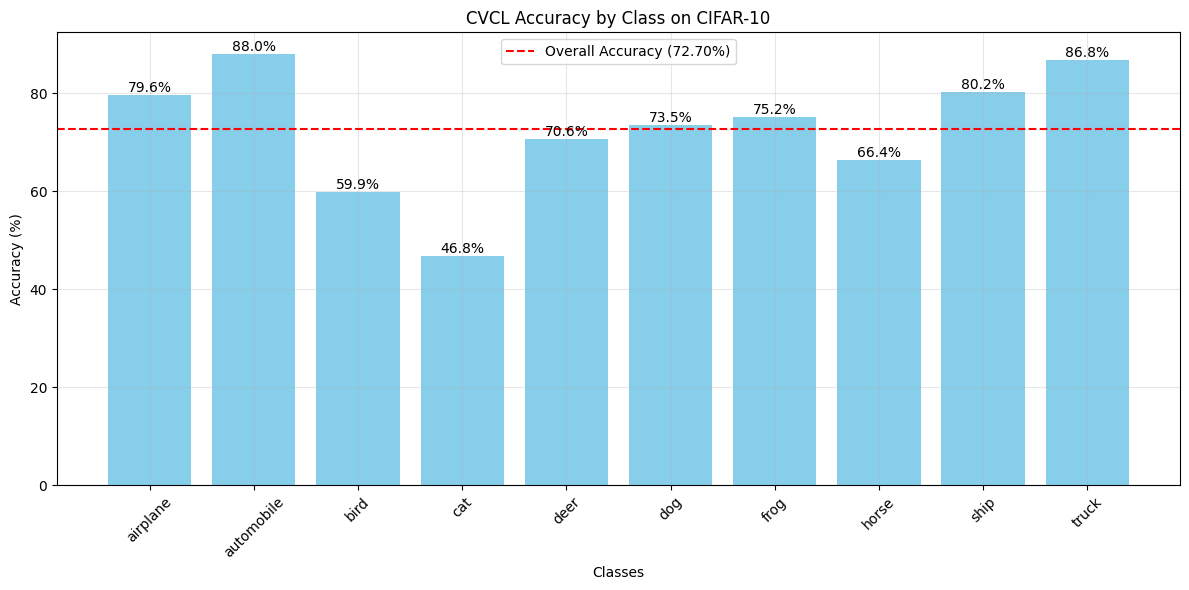

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 数据准备
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
accuracies = [79.60, 88.00, 59.90, 46.80, 70.60,
              73.50, 75.20, 66.40, 80.20, 86.80]

# 条形图
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, accuracies, color='skyblue')
plt.axhline(y=72.70, color='r', linestyle='--', label='Overall Accuracy (72.70%)')

# 在柱子上添加具体数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')

plt.title('CVCL Accuracy by Class on CIFAR-10')
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Zero-shot test in CIFA

<ipython-input-19-8aa44d4cc729>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


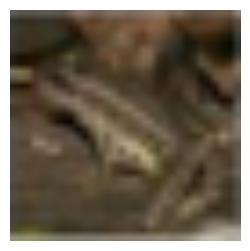


Image 1
True label: frog
Top 5 predictions:
      frog: 72.80%
      bird: 9.83%
      deer: 8.96%
automobile: 5.36%
     horse: 1.23%


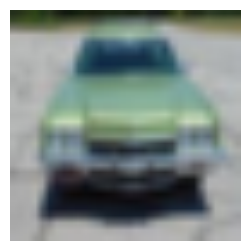


Image 2
True label: automobile
Top 5 predictions:
automobile: 69.80%
     truck: 19.86%
      ship: 7.95%
     horse: 0.99%
  airplane: 0.82%


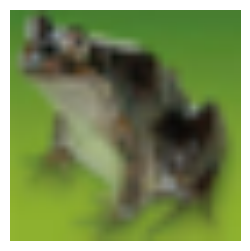


Image 3
True label: frog
Top 5 predictions:
       cat: 78.38%
       dog: 7.13%
  airplane: 5.41%
     truck: 3.44%
      frog: 2.06%


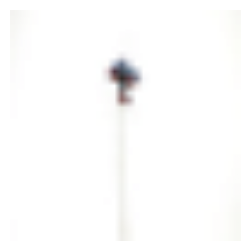


Image 4
True label: airplane
Top 5 predictions:
      bird: 46.21%
  airplane: 23.94%
      deer: 15.78%
       cat: 7.55%
      ship: 3.33%


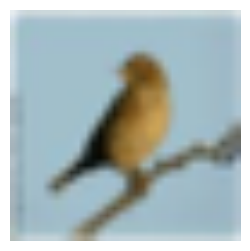


Image 5
True label: bird
Top 5 predictions:
      bird: 92.59%
  airplane: 3.39%
      deer: 1.12%
     horse: 0.97%
       cat: 0.68%


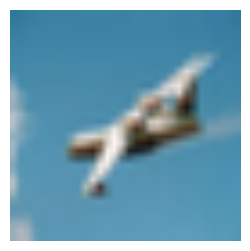


Image 6
True label: airplane
Top 5 predictions:
  airplane: 97.41%
      bird: 0.70%
      frog: 0.41%
automobile: 0.39%
     horse: 0.29%


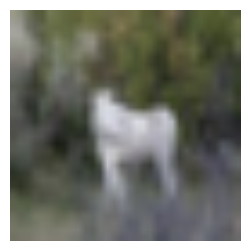


Image 7
True label: deer
Top 5 predictions:
      deer: 45.45%
       dog: 38.78%
       cat: 5.81%
      frog: 5.77%
      bird: 2.01%


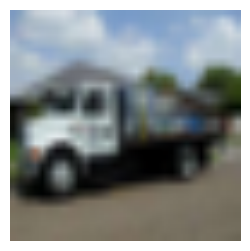


Image 8
True label: truck
Top 5 predictions:
     truck: 65.64%
automobile: 33.40%
  airplane: 0.20%
      ship: 0.18%
      frog: 0.16%


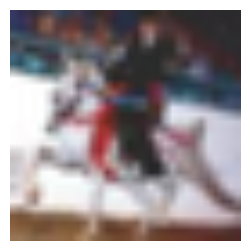


Image 9
True label: horse
Top 5 predictions:
     horse: 61.96%
      deer: 20.45%
      ship: 12.25%
      frog: 2.00%
       dog: 0.97%


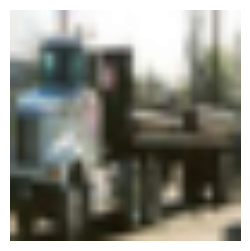


Image 10
True label: truck
Top 5 predictions:
     truck: 96.60%
automobile: 1.57%
  airplane: 0.79%
      ship: 0.62%
     horse: 0.22%


In [ ]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pickle
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class CIFAR10TestDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform

        test_batch_path = f"{data_path}/test_batch"
        test_dict = unpickle(test_batch_path)
        self.data = test_dict[b'data']
        self.labels = test_dict[b'labels']

        self.data = self.data.reshape(-1, 3, 32, 32)
        self.data = self.data.transpose(0, 2, 3, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, label

def show_image(image_tensor):
    img = image_tensor.cpu()
    img = img.permute(1, 2, 0)
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = img * std + mean
    img = img.numpy()
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

def zero_shot_test(model, dataset, num_samples=10):
    model.eval()
    device = next(model.parameters()).device

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), num_samples)

    with torch.no_grad():
        for i, idx in enumerate(random_indices, 1):
            image, label = dataset[idx]

            # 显示图片
            plt.figure(figsize=(3, 3))
            show_image(image)

            image = image.unsqueeze(0).to(device)

            # 获取模型输出
            output = model(image)
            probabilities = F.softmax(output, dim=1)[0]

            # 获取top 5预测及其概率
            top5_prob, top5_idx = torch.topk(probabilities, 5)

            # 打印结果
            print(f"\nImage {i}")
            print(f"True label: {classes[label]}")
            print("Top 5 predictions:")
            for prob, idx in zip(top5_prob, top5_idx):
                print(f"{classes[idx]:>10}: {prob.item()*100:.2f}%")

# 设置数据预处理
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# 创建测试数据集
test_dataset = CIFAR10TestDataset(
    data_path="/content/drive/MyDrive/Final_NLP/cifar-10-batches-py",
    transform=transform
)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载训练好的模型 - 适配新的保存方式
save_path = "/content/drive/MyDrive/trained_cvcl_model.pt"  # 修改为你的模型保存路径
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])  # 如果你只保存了模型权重，直接使用 torch.load(save_path)
model = model.to(device)

# 进行zero-shot测试
zero_shot_test(model, test_dataset, num_samples=10)

## Original Zero-shot in Cal101

### Model Prep

In [92]:
!git clone https://github.com/wkvong/multimodal-baby.git
!pip install -r "/content/multimodal-baby/requirements.txt"

fatal: destination path 'multimodal-baby' already exists and is not an empty directory.


In [93]:
!pip install huggingface_hub
!pip install pytorch-lightning==2.0.9
!pip install clip
!pip install -e /content/multimodal-baby

Obtaining file:///content/multimodal-baby
  Preparing metadata (setup.py) ... done
  Attempting uninstall: multimodal
    Found existing installation: multimodal 0.0.0
    Uninstalling multimodal-0.0.0:
      Successfully uninstalled multimodal-0.0.0
  Running setup.py develop for multimodal


In [94]:
import os
import sys
import torch
import clip
from PIL import Image

In [95]:
# 添加项目路径
project_path = "/content/multimodal-baby"
sys.path.append(project_path)

from multimodal.multimodal_lit import MultiModalLitModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

try:
    cvcl, preprocess = MultiModalLitModel.load_model(model_name="cvcl")
    cvcl = cvcl.to(device)
    cvcl.eval()
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {str(e)}")
    print("Detailed error info:", e.__class__.__name__)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=map_locati

Model loaded successfully


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.
  rank_zero_warn(


### Test and Plot

In [64]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

def pad_or_truncate(byte_list, target_length=32):
    """将字节列表填充或截断到指定长度"""
    if len(byte_list) > target_length:
        return byte_list[:target_length]
    return byte_list + [0] * (target_length - len(byte_list))

def convert_to_rgb(image):
    """确保图片是RGB格式"""
    if image.mode != 'RGB':
        return image.convert('RGB')
    return image

def get_class_names_from_path(dataset_path):
    pic_path = os.path.join(dataset_path, "pic")
    class_names = [d for d in os.listdir(pic_path) if os.path.isdir(os.path.join(pic_path, d))]
    return class_names

def prepare_text_input(class_names, max_length=32):
    """准备文本输入和对应的长度"""
    encoded_texts = []
    lengths = []

    for name in class_names:
        encoded = list(name.encode())
        original_length = len(encoded)
        padded = pad_or_truncate(encoded, max_length)
        encoded_texts.append(padded)
        lengths.append(min(original_length, max_length))

    return torch.tensor(encoded_texts), torch.tensor(lengths)

def perform_random_zero_shot(model, preprocess, dataset_path, num_samples=10):
    pic_path = os.path.join(dataset_path, "pic")
    class_names = get_class_names_from_path(dataset_path)

    all_images = []
    for class_name in class_names:
        class_path = os.path.join(pic_path, class_name)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        for img in images:
            all_images.append((os.path.join(class_path, img), class_name))

    selected_images = random.sample(all_images, num_samples)

    # 准备文本输入和长度
    text_inputs, text_lengths = prepare_text_input(class_names)
    text_inputs = text_inputs.to(device)
    text_lengths = text_lengths.to(device)

    for img_path, true_class in selected_images:
        try:
            image = Image.open(img_path)
            image = convert_to_rgb(image)
            image = preprocess(image).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(image, text_inputs, text_lengths)
                # 假设输出是元组，取第一个元素作为logits
                logits = outputs[0] if isinstance(outputs, tuple) else outputs
                probs = torch.nn.functional.softmax(logits, dim=1)

                values, indices = probs[0].topk(5)

                print(f"\nImage: {img_path}")
                print(f"True class: {true_class}")
                print("Top predictions:")
                for value, idx in zip(values, indices):
                    print(f"{class_names[idx]:>16}: {value.item()*100:.2f}%")
                print("-" * 50)

        except Exception as e:
            print(f"Error processing image {img_path}: {str(e)}")
            continue

def evaluate_model_performance(model, preprocess, dataset_path):
    pic_path = os.path.join(dataset_path, "pic")
    class_names = get_class_names_from_path(dataset_path)

    confusion_matrix = np.zeros((len(class_names), len(class_names)))
    class_accuracies = {}

    # 准备文本输入和长度
    text_inputs, text_lengths = prepare_text_input(class_names)
    text_inputs = text_inputs.to(device)
    text_lengths = text_lengths.to(device)

    for idx, class_name in enumerate(tqdm(class_names)):
        class_path = os.path.join(pic_path, class_name)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        correct = 0
        total = 0

        for img_name in images:
            try:
                img_path = os.path.join(class_path, img_name)
                image = Image.open(img_path)
                image = convert_to_rgb(image)
                image = preprocess(image).unsqueeze(0).to(device)

                with torch.no_grad():
                    outputs = model(image, text_inputs, text_lengths)
                    # 假设输出是元组，取第一个元素作为logits
                    logits = outputs[0] if isinstance(outputs, tuple) else outputs
                    probs = torch.nn.functional.softmax(logits, dim=1)
                    pred = probs[0].argmax().item()

                    confusion_matrix[idx][pred] += 1
                    if class_names[pred] == class_name:
                        correct += 1
                    total += 1

            except Exception as e:
                print(f"Error processing image {img_path}: {str(e)}")
                continue

        accuracy = (correct / total) * 100 if total > 0 else 0
        class_accuracies[class_name] = accuracy

    # 绘制准确率柱状图
    plt.figure(figsize=(15, 6))
    plt.bar(class_accuracies.keys(), class_accuracies.values())
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy (%)')
    plt.title('CVCL Model Accuracy by Class')
    for i, v in enumerate(class_accuracies.values()):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center')
    plt.tight_layout()
    plt.show()

    # 绘制混淆矩阵
    plt.figure(figsize=(12, 10))
    confusion_matrix_percent = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True) * 100
    sns.heatmap(confusion_matrix_percent, annot=True, fmt='.1f',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# 确保设备正确设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 使用示例
dataset_path = "/content/drive/MyDrive/Final_NLP/dataset"

In [36]:
# 1. 执行随机10张图片的zero-shot测试
print("Performing random zero-shot predictions...")
perform_random_zero_shot(cvcl, preprocess, dataset_path, num_samples=10)

Performing random zero-shot predictions...

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/pizza/image_0051.jpg
True class: pizza
Top predictions:
           watch: 12.71%
        scissors: 11.88%
   windsor_chair: 10.21%
       airplanes: 9.86%
      wheelchair: 9.17%
--------------------------------------------------

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/Motorbikes/image_0537.jpg
True class: Motorbikes
Top predictions:
        wild_cat: 24.84%
     soccer_ball: 10.60%
           watch: 9.22%
           pizza: 8.72%
       butterfly: 8.21%
--------------------------------------------------

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/ceiling_fan/image_0024.jpg
True class: ceiling_fan
Top predictions:
           chair: 16.64%
 electric_guitar: 15.01%
     ceiling_fan: 13.92%
       airplanes: 9.87%
   windsor_chair: 7.33%
--------------------------------------------------

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/airplanes/image_0527.jpg
True clas


Evaluating model performance on the entire dataset...


100%|██████████| 16/16 [04:51<00:00, 18.21s/it]


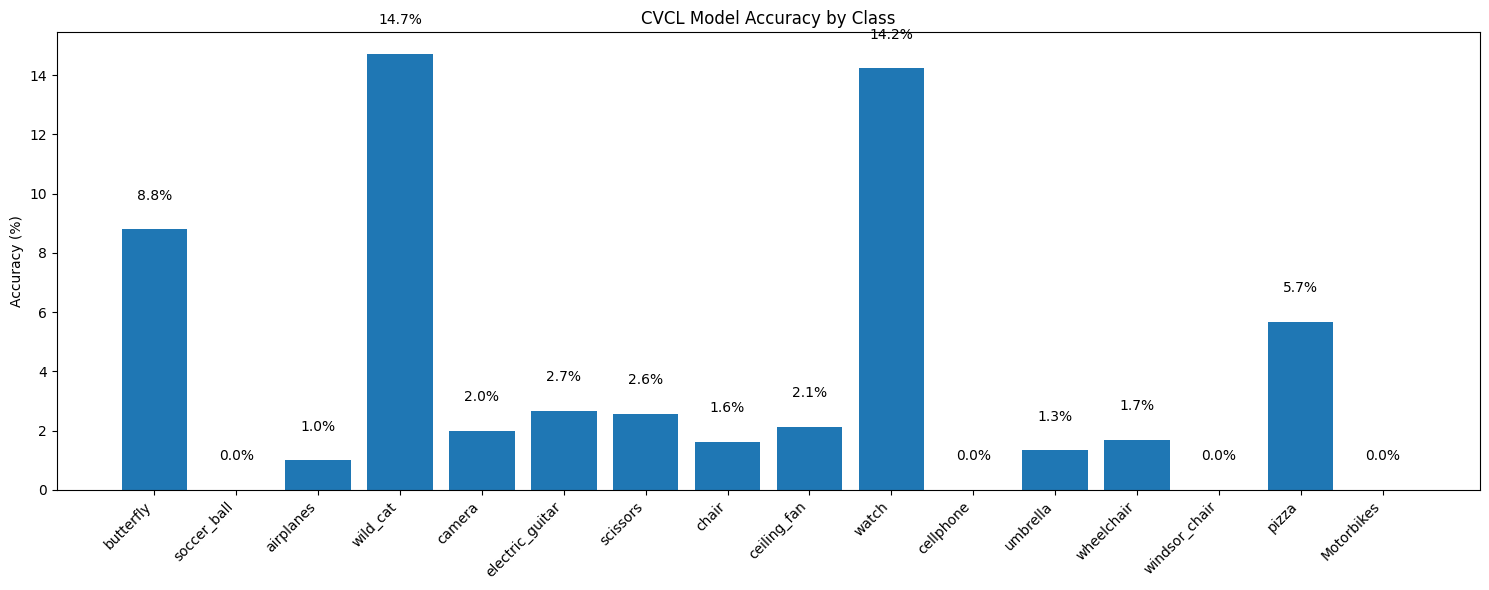

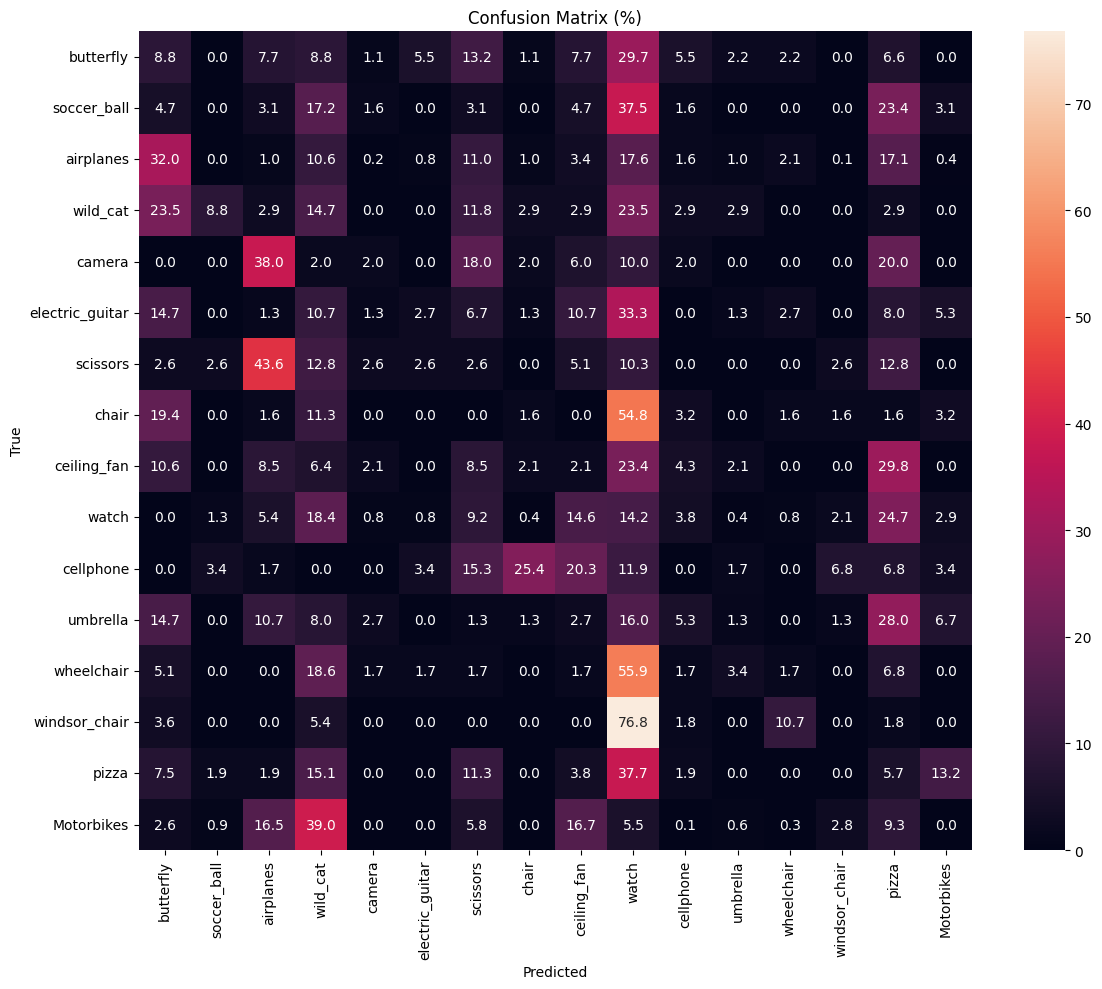

In [37]:
# 2. 评估模型在整个数据集上的表现
print("\nEvaluating model performance on the entire dataset...")
evaluate_model_performance(cvcl, preprocess, dataset_path)

In [96]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import accuracy_score

def pad_or_truncate(byte_list, target_length=32):
    if len(byte_list) > target_length:
        return byte_list[:target_length]
    return byte_list + [0] * (target_length - len(byte_list))

def convert_to_rgb(image):
    if image.mode != 'RGB':
        return image.convert('RGB')
    return image

def get_class_names_from_path(dataset_path):
    pic_path = os.path.join(dataset_path, "pic")
    class_names = [d for d in os.listdir(pic_path) if os.path.isdir(os.path.join(pic_path, d))]
    return class_names

def prepare_text_input(class_names, max_length=32):
    encoded_texts = []
    lengths = []

    for name in class_names:
        encoded = list(name.encode())
        original_length = len(encoded)
        padded = pad_or_truncate(encoded, max_length)
        encoded_texts.append(padded)
        lengths.append(min(original_length, max_length))

    return torch.tensor(encoded_texts), torch.tensor(lengths)

def calculate_accuracies(y_true, y_pred, class_names):
    # Initialize counters for each class
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    # Count correct predictions and totals for each class
    for true, pred in zip(y_true, y_pred):
        class_total[true] += 1
        if true == pred:
            class_correct[true] += 1

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_true, y_pred) * 100

    # Print detailed results
    print("Detailed class accuracies:")
    for class_name in class_names:
        total = class_total[class_name]
        correct = class_correct[class_name]
        if total == 0:
            accuracy = 0.0
        else:
            accuracy = (correct / total) * 100

        print(f"{class_name:<15}: {accuracy:.2f}% ({correct}/{total})")

    print(f"\nOverall accuracy: {overall_accuracy:.2f}%")

def evaluate_model_performance(model, preprocess, dataset_path):
    pic_path = os.path.join(dataset_path, "pic")
    class_names = get_class_names_from_path(dataset_path)

    y_true = []  # 存储真实标签
    y_pred = []  # 存储预测标签

    # 准备文本输入和长度
    text_inputs, text_lengths = prepare_text_input(class_names)
    text_inputs = text_inputs.to(device)
    text_lengths = text_lengths.to(device)

    for idx, class_name in enumerate(tqdm(class_names)):
        class_path = os.path.join(pic_path, class_name)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for img_name in images:
            try:
                img_path = os.path.join(class_path, img_name)
                image = Image.open(img_path)
                image = convert_to_rgb(image)
                image = preprocess(image).unsqueeze(0).to(device)

                with torch.no_grad():
                    outputs = model(image, text_inputs, text_lengths)
                    logits = outputs[0] if isinstance(outputs, tuple) else outputs
                    probs = torch.nn.functional.softmax(logits, dim=1)
                    pred = probs[0].argmax().item()

                    y_true.append(class_name)
                    y_pred.append(class_names[pred])

            except Exception as e:
                print(f"Error processing image {img_path}: {str(e)}")
                continue

    # 调用calculate_accuracies函数计算并显示结果
    calculate_accuracies(y_true, y_pred, class_names)

# 确保设备正确设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 使用示例
dataset_path = "/content/drive/MyDrive/Final_NLP/dataset"

evaluate_model_performance(model, preprocess, dataset_path)

100%|██████████| 16/16 [01:01<00:00,  3.83s/it]

Detailed class accuracies:
butterfly      : 8.79% (8/91)
soccer_ball    : 0.00% (0/64)
airplanes      : 1.00% (8/800)
wild_cat       : 14.71% (5/34)
camera         : 2.00% (1/50)
electric_guitar: 2.67% (2/75)
scissors       : 2.56% (1/39)
chair          : 1.61% (1/62)
ceiling_fan    : 2.13% (1/47)
watch          : 14.23% (34/239)
cellphone      : 0.00% (0/59)
umbrella       : 1.33% (1/75)
wheelchair     : 1.69% (1/59)
windsor_chair  : 0.00% (0/56)
pizza          : 5.66% (3/53)
Motorbikes     : 0.00% (0/798)

Overall accuracy: 2.54%


## Trained Zero-shot in Cal101

#### Try 1

In [72]:
import os
import sys
import torch
from multimodal.multimodal_lit import MultiModalLitModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    # 使用官方的加载方法
    model, preprocess = MultiModalLitModel.load_model(
        model_name="cvcl",
        device=device,
        jit=False
    )

    model = model.to(device)
    model.eval()
    print("Model loaded successfully")

except Exception as e:
    print(f"Error type: {type(e)}")
    print(f"Error message: {str(e)}")
    import traceback
    traceback.print_exc()

Error type: <class 'TypeError'>
Error message: MultiModalLitModel.load_model() got an unexpected keyword argument 'device'


Traceback (most recent call last):
  File "<ipython-input-72-ea2d78973eac>", line 10, in <cell line: 8>
    model, preprocess = MultiModalLitModel.load_model(
TypeError: MultiModalLitModel.load_model() got an unexpected keyword argument 'device'


In [89]:
import os
import sys
import torch
from multimodal.multimodal_lit import MultiModalLitModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    # 只使用model_name参数
    model, preprocess = MultiModalLitModel.load_model(model_name="cvcl")

    # 之后再将模型移动到指定设备
    model = model.to(device)
    model.eval()
    print("Model loaded successfully")

    # 测试模型是否正常工作
    test_texts = ["ball", "puzzle", "car"]
    texts, texts_len = model.tokenize(test_texts)
    texts, texts_len = texts.to(device), texts_len.to(device)

    # 创建随机测试图像
    test_images = torch.rand(1, 3, 224, 224).to(device)

    # 进行测试推理
    with torch.no_grad():
        image_features = model.encode_image(test_images)
        text_features = model.encode_text(texts, texts_len)
        print("Test inference successful")

except Exception as e:
    print(f"Error type: {type(e)}")
    print(f"Error message: {str(e)}")
    import traceback
    traceback.print_exc()

    # 打印更多调试信息
    print("\nDebug information:")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Python path: {sys.path}")
    print(f"Available methods in MultiModalLitModel: {dir(MultiModalLitModel)}")

/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=map_locati

Model loaded successfully
Test inference successful


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.
  rank_zero_warn(


In [74]:
# 1. 执行随机10张图片的zero-shot测试
print("Performing random zero-shot predictions...")
perform_random_zero_shot(model, preprocess, dataset_path, num_samples=10)

Performing random zero-shot predictions...

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/Motorbikes/image_0178.jpg
True class: Motorbikes
Top predictions:
        wild_cat: 21.98%
     ceiling_fan: 12.10%
           pizza: 10.31%
           watch: 7.52%
       airplanes: 7.45%
--------------------------------------------------

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/airplanes/image_0365.jpg
True class: airplanes
Top predictions:
       butterfly: 26.38%
           watch: 16.23%
        scissors: 9.12%
           chair: 8.74%
      wheelchair: 5.79%
--------------------------------------------------

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/Motorbikes/image_0776.jpg
True class: Motorbikes
Top predictions:
        wild_cat: 20.23%
       airplanes: 16.45%
   windsor_chair: 13.75%
           pizza: 10.80%
     ceiling_fan: 7.95%
--------------------------------------------------

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/airplanes/image_0005.jpg
Tr


Evaluating model performance on the entire dataset...


100%|██████████| 16/16 [00:51<00:00,  3.25s/it]


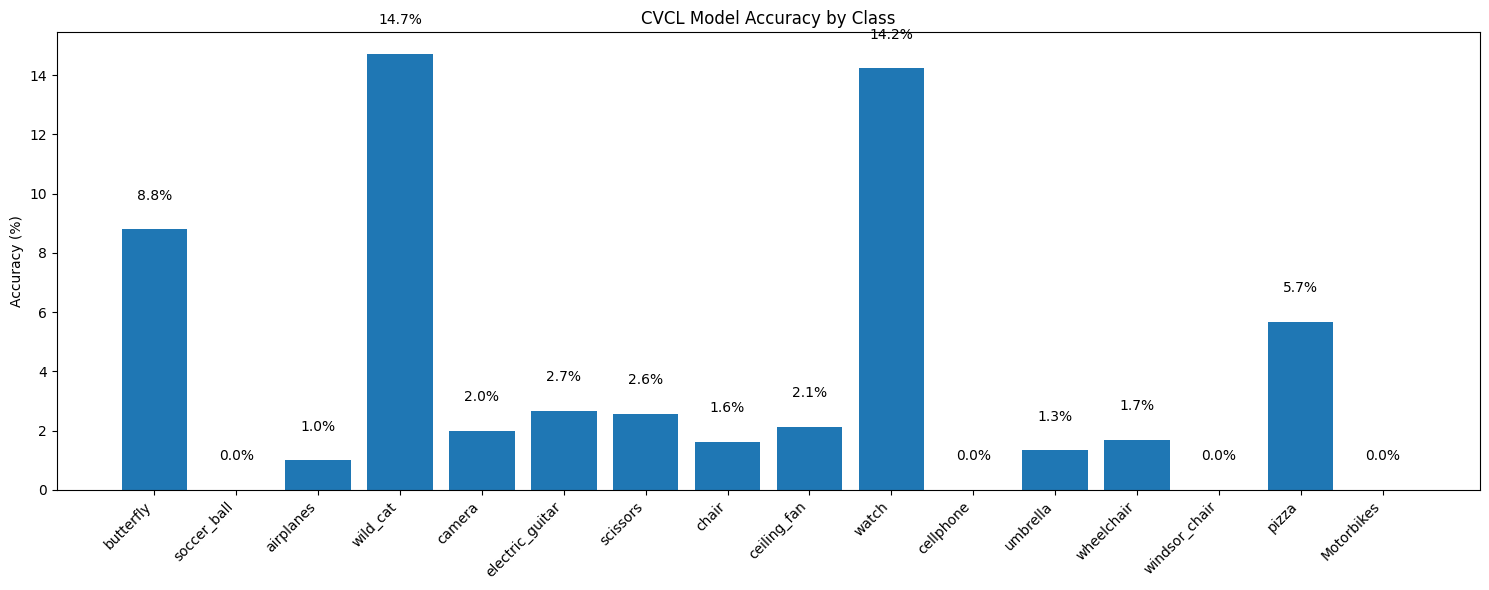

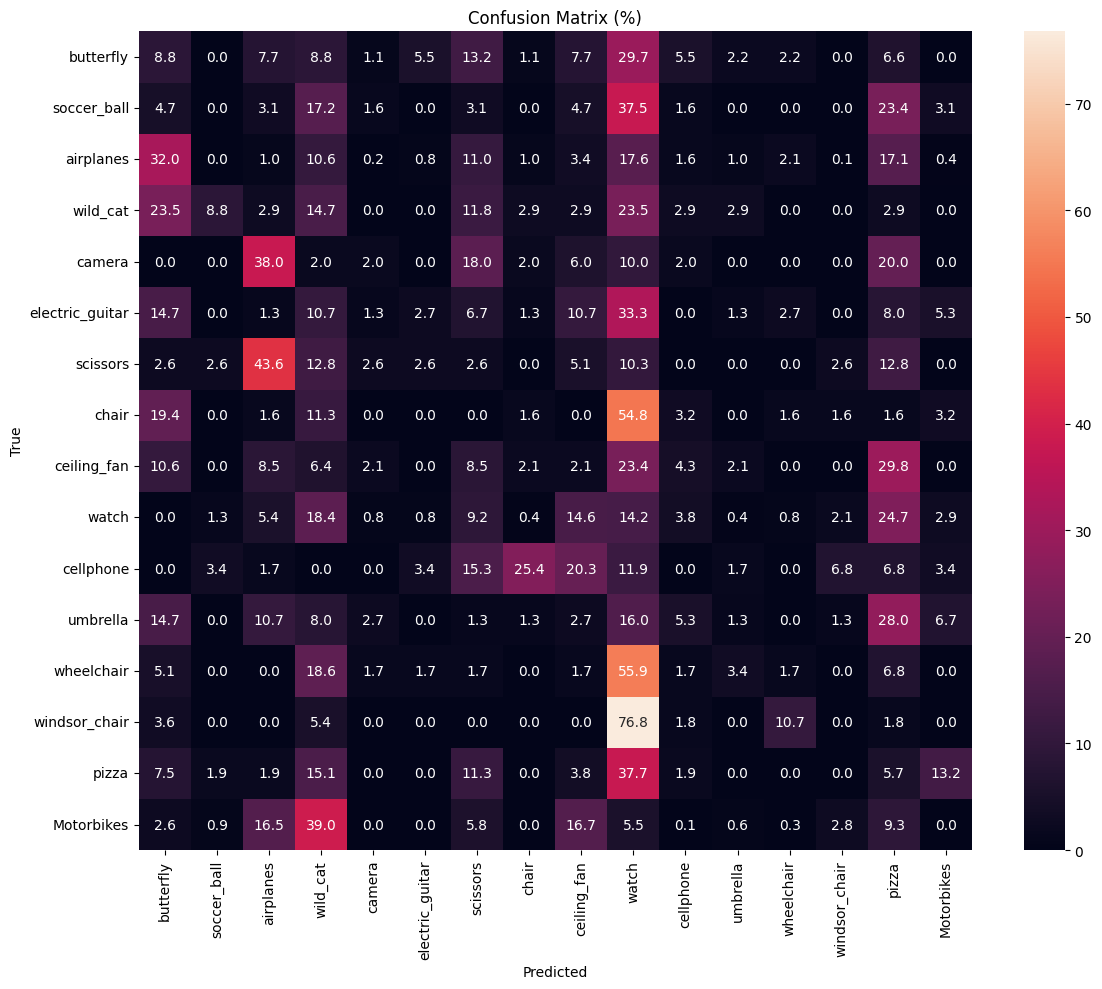

In [75]:
# 2. 评估模型在整个数据集上的表现
print("\nEvaluating model performance on the entire dataset...")
evaluate_model_performance(model, preprocess, dataset_path)

In [91]:
def evaluate_model_performance(model, preprocess, dataset_path):
    pic_path = os.path.join(dataset_path, "pic")
    class_names = get_class_names_from_path(dataset_path)

    y_true = []  # 存储真实标签
    y_pred = []  # 存储预测标签

    # 准备文本输入和长度
    text_inputs, text_lengths = prepare_text_input(class_names)
    text_inputs = text_inputs.to(device)
    text_lengths = text_lengths.to(device)

    for idx, class_name in enumerate(tqdm(class_names)):
        class_path = os.path.join(pic_path, class_name)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for img_name in images:
            try:
                img_path = os.path.join(class_path, img_name)
                image = Image.open(img_path)
                image = convert_to_rgb(image)
                image = preprocess(image).unsqueeze(0).to(device)

                with torch.no_grad():
                    outputs = model(image, text_inputs, text_lengths)
                    logits = outputs[0] if isinstance(outputs, tuple) else outputs
                    probs = torch.nn.functional.softmax(logits, dim=1)
                    pred = probs[0].argmax().item()

                    y_true.append(class_name)
                    y_pred.append(class_names[pred])

            except Exception as e:
                print(f"Error processing image {img_path}: {str(e)}")
                continue

    # 调用calculate_accuracies函数计算并显示结果
    calculate_accuracies(y_true, y_pred, class_names)

# 使用示例
dataset_path = "/content/drive/MyDrive/Final_NLP/dataset"
evaluate_model_performance(model, preprocess, dataset_path)

100%|██████████| 16/16 [00:55<00:00,  3.45s/it]

Detailed class accuracies:
butterfly      : 8.79% (8/91)
soccer_ball    : 0.00% (0/64)
airplanes      : 1.00% (8/800)
wild_cat       : 14.71% (5/34)
camera         : 2.00% (1/50)
electric_guitar: 2.67% (2/75)
scissors       : 2.56% (1/39)
chair          : 1.61% (1/62)
ceiling_fan    : 2.13% (1/47)
watch          : 14.23% (34/239)
cellphone      : 0.00% (0/59)
umbrella       : 1.33% (1/75)
wheelchair     : 1.69% (1/59)
windsor_chair  : 0.00% (0/56)
pizza          : 5.66% (3/53)
Motorbikes     : 0.00% (0/798)

Overall accuracy: 2.54%


#### Try 2

In [97]:
import os
import sys
import torch
from multimodal.multimodal_lit import MultiModalLitModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    # 首先加载预训练模型
    model, preprocess = MultiModalLitModel.load_model(model_name="cvcl")

    # 加载您的训练权重
    checkpoint_path = "/content/drive/MyDrive/trained_cvcl_model.pt"
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # 加载权重到模型
    if 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint)

    # 将模型移动到指定设备并设置为评估模式
    model = model.to(device)
    model.eval()
    print("Model loaded successfully with trained weights")

    # 测试模型是否正常工作
    test_texts = ["ball", "puzzle", "car"]
    texts, texts_len = model.tokenize(test_texts)
    texts, texts_len = texts.to(device), texts_len.to(device)

    # 创建随机测试图像
    test_images = torch.rand(1, 3, 224, 224).to(device)

    # 进行测试推理
    with torch.no_grad():
        image_features = model.encode_image(test_images)
        text_features = model.encode_text(texts, texts_len)
        print("Test inference successful")

except Exception as e:
    print(f"Error type: {type(e)}")
    print(f"Error message: {str(e)}")
    import traceback
    traceback.print_exc()

    # 打印更多调试信息
    print("\nDebug information:")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Python path: {sys.path}")
    print(f"Available methods in MultiModalLitModel: {dir(MultiModalLitModel)}")

# 1. 执行随机10张图片的zero-shot测试
print("Performing random zero-shot predictions...")
perform_random_zero_shot(model, preprocess, dataset_path, num_samples=10)

# 2. 评估模型在整个数据集上的表现
print("\nEvaluating model performance on the entire dataset...")
evaluate_model_performance(model, preprocess, dataset_path)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=map_locati

Error type: <class 'RuntimeError'>
Error message: Error(s) in loading state_dict for MultiModalLitModel:
	Missing key(s) in state_dict: "vision_encoder.model.conv1.weight", "vision_encoder.model.bn1.weight", "vision_encoder.model.bn1.bias", "vision_encoder.model.bn1.running_mean", "vision_encoder.model.bn1.running_var", "vision_encoder.model.layer1.0.conv1.weight", "vision_encoder.model.layer1.0.bn1.weight", "vision_encoder.model.layer1.0.bn1.bias", "vision_encoder.model.layer1.0.bn1.running_mean", "vision_encoder.model.layer1.0.bn1.running_var", "vision_encoder.model.layer1.0.conv2.weight", "vision_encoder.model.layer1.0.bn2.weight", "vision_encoder.model.layer1.0.bn2.bias", "vision_encoder.model.layer1.0.bn2.running_mean", "vision_encoder.model.layer1.0.bn2.running_var", "vision_encoder.model.layer1.0.conv3.weight", "vision_encoder.model.layer1.0.bn3.weight", "vision_encoder.model.layer1.0.bn3.bias", "vision_encoder.model.layer1.0.bn3.running_mean", "vision_encoder.model.layer1.0.bn3

Traceback (most recent call last):
  File "<ipython-input-97-bf5262f1cb81>", line 20, in <cell line: 8>
    model.load_state_dict(checkpoint)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 2584, in load_state_dict
    raise RuntimeError(
RuntimeError: Error(s) in loading state_dict for MultiModalLitModel:
	Missing key(s) in state_dict: "vision_encoder.model.conv1.weight", "vision_encoder.model.bn1.weight", "vision_encoder.model.bn1.bias", "vision_encoder.model.bn1.running_mean", "vision_encoder.model.bn1.running_var", "vision_encoder.model.layer1.0.conv1.weight", "vision_encoder.model.layer1.0.bn1.weight", "vision_encoder.model.layer1.0.bn1.bias", "vision_encoder.model.layer1.0.bn1.running_mean", "vision_encoder.model.layer1.0.bn1.running_var", "vision_encoder.model.layer1.0.conv2.weight", "vision_encoder.model.layer1.0.bn2.weight", "vision_encoder.model.layer1.0.bn2.bias", "vision_encoder.model.layer1.0.bn2.running_mean", "vision_encoder.model.layer1


Image: /content/drive/MyDrive/Final_NLP/dataset/pic/airplanes/image_0786.jpg
True class: airplanes
Top predictions:
       airplanes: 14.03%
      wheelchair: 13.52%
       cellphone: 10.84%
           pizza: 9.02%
        umbrella: 7.20%
--------------------------------------------------

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/Motorbikes/image_0503.jpg
True class: Motorbikes
Top predictions:
      Motorbikes: 25.46%
        scissors: 11.05%
       airplanes: 9.95%
     soccer_ball: 8.84%
           pizza: 8.29%
--------------------------------------------------

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/windsor_chair/image_0052.jpg
True class: windsor_chair
Top predictions:
       cellphone: 17.18%
        scissors: 11.70%
           watch: 10.20%
       butterfly: 9.65%
     soccer_ball: 9.13%
--------------------------------------------------

Image: /content/drive/MyDrive/Final_NLP/dataset/pic/airplanes/image_0638.jpg
True class: airplanes
Top predictions:
 

100%|██████████| 16/16 [01:10<00:00,  4.41s/it]

Detailed class accuracies:
butterfly      : 13.19% (12/91)
soccer_ball    : 0.00% (0/64)
airplanes      : 7.75% (62/800)
wild_cat       : 0.00% (0/34)
camera         : 4.00% (2/50)
electric_guitar: 5.33% (4/75)
scissors       : 12.82% (5/39)
chair          : 1.61% (1/62)
ceiling_fan    : 4.26% (2/47)
watch          : 4.18% (10/239)
cellphone      : 30.51% (18/59)
umbrella       : 0.00% (0/75)
wheelchair     : 1.69% (1/59)
windsor_chair  : 0.00% (0/56)
pizza          : 22.64% (12/53)
Motorbikes     : 2.01% (16/798)

Overall accuracy: 5.57%


In [98]:
def evaluate_model_performance(model, preprocess, dataset_path):
    pic_path = os.path.join(dataset_path, "pic")
    class_names = get_class_names_from_path(dataset_path)

    confusion_matrix = np.zeros((len(class_names), len(class_names)))
    class_accuracies = {}

    # 准备文本输入和长度
    text_inputs, text_lengths = prepare_text_input(class_names)
    text_inputs = text_inputs.to(device)
    text_lengths = text_lengths.to(device)

    # 使用tqdm显示进度
    for idx, class_name in enumerate(tqdm(class_names)):
        class_path = os.path.join(pic_path, class_name)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        correct = 0
        total = 0

        for img_name in images:
            try:
                img_path = os.path.join(class_path, img_name)
                image = Image.open(img_path)
                image = convert_to_rgb(image)
                image = preprocess(image).unsqueeze(0).to(device)

                with torch.no_grad():
                    outputs = model(image, text_inputs, text_lengths)
                    logits = outputs[0] if isinstance(outputs, tuple) else outputs
                    probs = torch.nn.functional.softmax(logits, dim=1)
                    pred = probs[0].argmax().item()

                    confusion_matrix[idx][pred] += 1
                    if class_names[pred] == class_name:
                        correct += 1
                    total += 1

            except Exception as e:
                print(f"Error processing image {img_path}: {str(e)}")
                continue

        accuracy = (correct / total) * 100 if total > 0 else 0
        class_accuracies[class_name] = accuracy

    # 绘制准确率柱状图
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(class_accuracies)), list(class_accuracies.values()), color='#2171b5')
    plt.xticks(range(len(class_accuracies)), list(class_accuracies.keys()), rotation=45, ha='right')
    plt.ylabel('Accuracy (%)')
    plt.title('CVCL Model Accuracy by Class')

    # 在每个柱子顶部添加准确率数值
    for i, v in enumerate(class_accuracies.values()):
        plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # 计算混淆矩阵的百分比
    confusion_matrix_percent = np.zeros_like(confusion_matrix)
    for i in range(confusion_matrix.shape[0]):
        row_sum = confusion_matrix[i].sum()
        if row_sum > 0:
            confusion_matrix_percent[i] = confusion_matrix[i] / row_sum * 100

    # 绘制混淆矩阵热力图
    plt.figure(figsize=(15, 12))

    # 使用自定义颜色映射
    cmap = sns.color_palette("rocket_r", as_cmap=True)

    # 绘制热力图
    sns.heatmap(confusion_matrix_percent,
                annot=True,
                fmt='.1f',
                cmap=cmap,
                xticklabels=class_names,
                yticklabels=class_names,
                vmin=0,
                vmax=100)

    plt.title('Confusion Matrix (%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # 调整布局以确保标签可见
    plt.tight_layout()
    plt.show()

    # 打印每个类别的准确率
    print("\nAccuracy for each class:")
    for class_name, accuracy in class_accuracies.items():
        print(f"{class_name:<15}: {accuracy:.2f}%")

    # 计算并打印总体准确率
    overall_accuracy = sum(class_accuracies.values()) / len(class_accuracies)
    print(f"\nOverall accuracy: {overall_accuracy:.2f}%")


Evaluating model performance on the entire dataset...


100%|██████████| 16/16 [00:58<00:00,  3.63s/it]


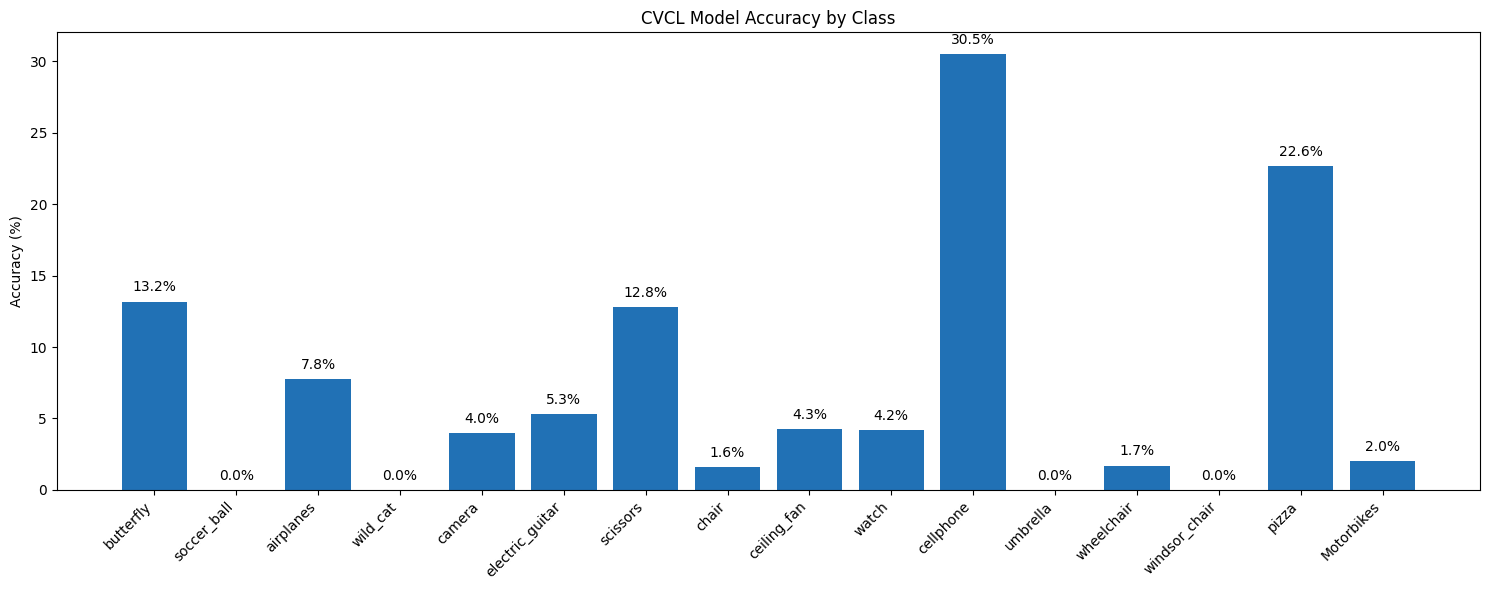

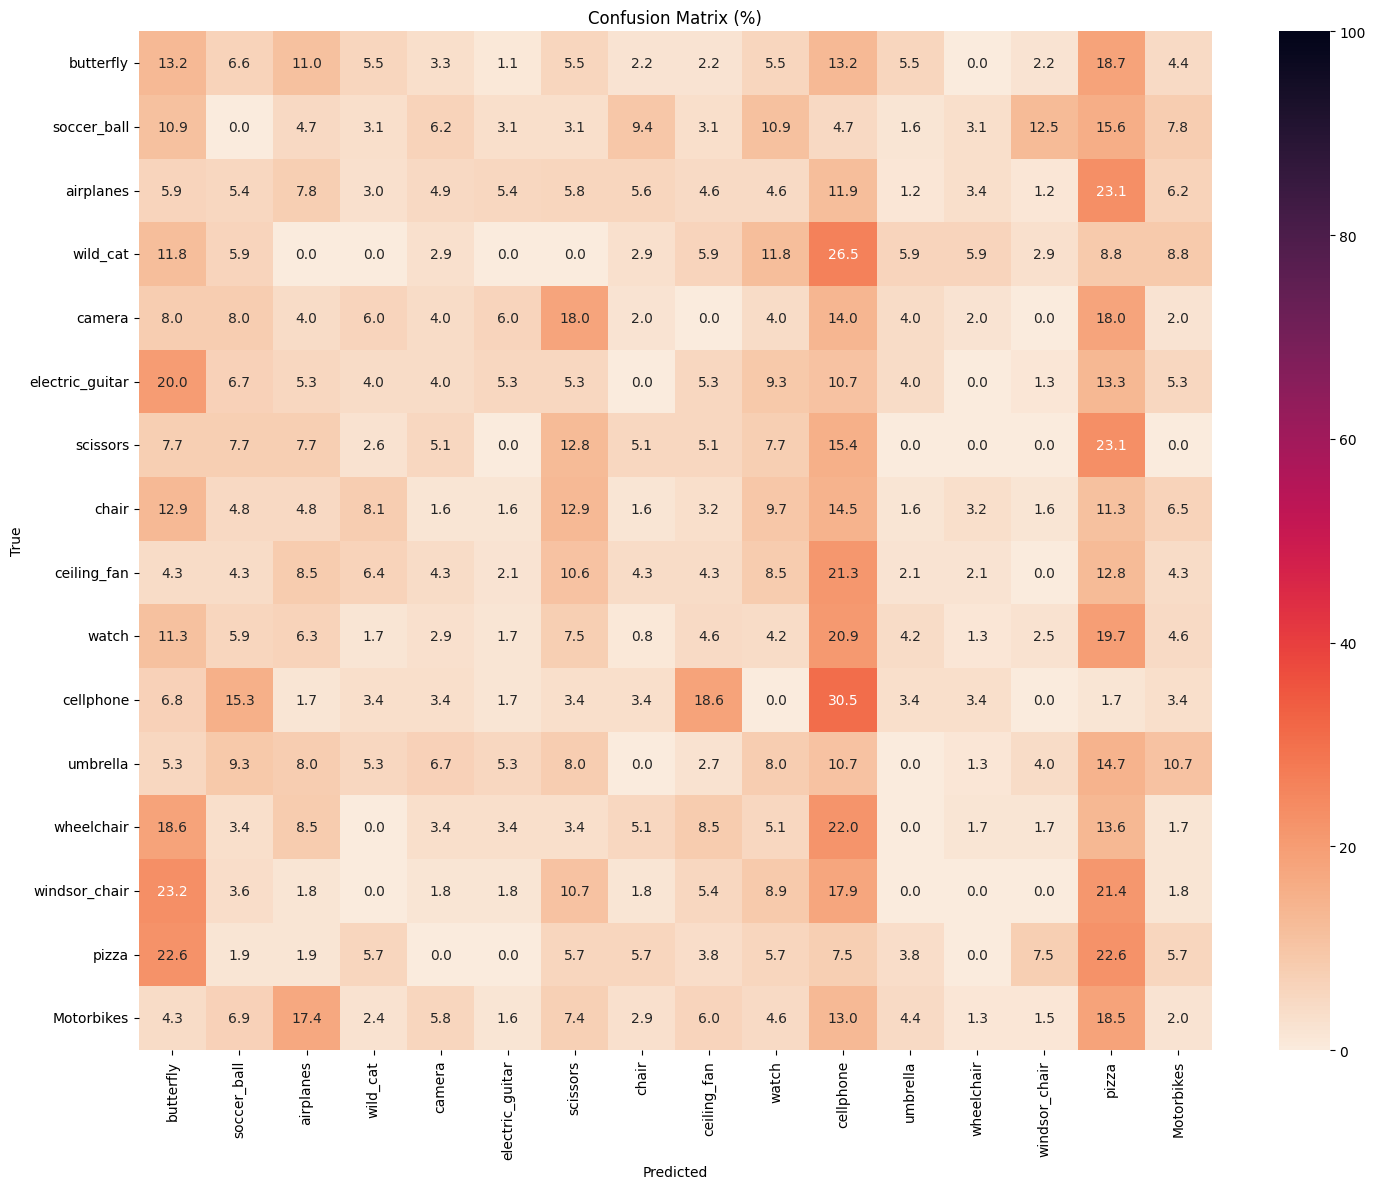


Accuracy for each class:
butterfly      : 13.19%
soccer_ball    : 0.00%
airplanes      : 7.75%
wild_cat       : 0.00%
camera         : 4.00%
electric_guitar: 5.33%
scissors       : 12.82%
chair          : 1.61%
ceiling_fan    : 4.26%
watch          : 4.18%
cellphone      : 30.51%
umbrella       : 0.00%
wheelchair     : 1.69%
windsor_chair  : 0.00%
pizza          : 22.64%
Motorbikes     : 2.01%

Overall accuracy: 6.87%


In [99]:
# 2. 评估模型在整个数据集上的表现
print("\nEvaluating model performance on the entire dataset...")
evaluate_model_performance(model, preprocess, dataset_path)

# Siamese Network

## Model Prep

In [76]:
!pip install torch torchvision pillow matplotlib seaborn scipy

# 导入必要的库
import os
import random
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import scipy.io as sio
from google.colab import drive
import pandas as pd

In [77]:
# 设置随机种子确保可重复性
random.seed(42)
torch.manual_seed(42)

# 定义数据路径
base_path = "/content/drive/MyDrive/Final_NLP/dataset"
pic_path = os.path.join(base_path, "pic")
annotate_path = os.path.join(base_path, "annotate")

In [84]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from collections import defaultdict
import random
from google.colab import drive
import torch.nn as nn
import sys
import torchvision.models as models

# 克隆SimSiam仓库
if not os.path.exists('simsiam'):
    !git clone https://github.com/facebookresearch/simsiam.git
sys.path.append('simsiam')

# 使用ResNet50的预训练权重作为替代
print("Using pretrained ResNet50 as backbone...")
backbone = models.resnet50(pretrained=True)

from simsiam.builder import SimSiam

# 挂载Google Drive
drive.mount('/content/drive')

# 修改CustomSimSiam类
class CustomSimSiam(nn.Module):
    def __init__(self, num_classes=len(TARGET_CLASSES)):
        super(CustomSimSiam, self).__init__()
        # 使用预训练的ResNet50
        self.encoder = backbone
        # 移除最后的FC层
        self.encoder.fc = nn.Identity()
        # 添加新的分类头
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        # 获取特征
        feat = self.encoder(x)
        # 分类
        out = self.classifier(feat)
        return out

print("Initializing model...")
# 初始化模型
model = CustomSimSiam()
model.eval()
print("Model initialized!")

def evaluate_dataset():
    # 创建统计数据的字典
    class_stats = defaultdict(lambda: {'correct': 0, 'total': 0})
    total_correct = 0
    total_samples = 0

    # 遍历目标类别
    for class_name in TARGET_CLASSES:
        class_dir = os.path.join(pic_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        for img_name in os.listdir(class_dir):
            if not img_name.endswith('.jpg'):
                continue

            img_path = os.path.join(class_dir, img_name)
            try:
                # 加载和预处理图像
                image = Image.open(img_path).convert('RGB')
                image = transform(image).unsqueeze(0)

                # 进行预测
                with torch.no_grad():
                    output = model(image)
                    _, predicted = torch.max(output.data, 1)

                # 更新统计信息
                class_stats[class_name]['total'] += 1
                total_samples += 1

                # 检查预测是否正确
                true_class_idx = class_to_idx[class_name]
                if predicted.item() == true_class_idx:
                    class_stats[class_name]['correct'] += 1
                    total_correct += 1

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                continue

    # 输出详细结果
    print("Detailed class accuracies:")
    for class_name in TARGET_CLASSES:
        stats = class_stats[class_name]
        if stats['total'] > 0:
            accuracy = (stats['correct'] / stats['total'] * 100)
        else:
            accuracy = 0.0
        print(f"{class_name:<15}: {accuracy:.2f}% ({stats['correct']}/{stats['total']})")

    # 输出整体准确率
    if total_samples > 0:
        overall_accuracy = (total_correct / total_samples * 100)
    else:
        overall_accuracy = 0.0
    print(f"\nOverall accuracy: {overall_accuracy:.2f}%")

    return class_stats, overall_accuracy

def predict_single_image(image_path):
    """预测单张图片的类别"""
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0)

        with torch.no_grad():
            output = model(image)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            top_prob, top_class = torch.topk(probabilities, 5)

        # 输出预测结果
        print(f"\nPredictions for {os.path.basename(image_path)}:")
        for prob, cls_idx in zip(top_prob[0], top_class[0]):
            class_name = TARGET_CLASSES[cls_idx]
            print(f"{class_name}: {prob.item()*100:.2f}%")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")


Using pretrained ResNet50 as backbone...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initializing model...
Model initialized!


## Zero-shot and test in Cal101

In [85]:
if __name__ == "__main__":
    print("Starting evaluation...")

    # 评估整个数据集
    print("\nEvaluating full dataset...")
    class_stats, overall_accuracy = evaluate_dataset()

    # 随机选择10张图片进行预测示例
    print("\nPredicting 10 random images...")
    all_images = []
    for class_name in TARGET_CLASSES:
        class_dir = os.path.join(pic_path, class_name)
        if os.path.isdir(class_dir):
            images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.jpg')]
            all_images.extend(images)

    if all_images:
        random_images = random.sample(all_images, min(10, len(all_images)))
        for img_path in random_images:
            predict_single_image(img_path)

Starting evaluation...

Evaluating full dataset...
Detailed class accuracies:
windsor_chair  : 25.00% (14/56)
wild_cat       : 0.00% (0/34)
wheelchair     : 0.00% (0/59)
watch          : 0.00% (0/239)
umbrella       : 0.00% (0/75)
soccer_ball    : 0.00% (0/64)
scissors       : 0.00% (0/39)
pizza          : 7.55% (4/53)
electric_guitar: 1.33% (1/75)
chair          : 12.90% (8/62)
cellphone      : 3.39% (2/59)
ceiling_fan    : 8.51% (4/47)
camera         : 2.00% (1/50)
butterfly      : 18.68% (17/91)
Motorbikes_16  : 0.00% (0/0)
Airplanes_Side_2: 0.00% (0/0)

Overall accuracy: 5.08%

Predicting 10 random images...

Predictions for image_0030.jpg:
Motorbikes_16: 9.13%
wheelchair: 7.72%
chair: 7.60%
butterfly: 7.38%
camera: 7.24%

Predictions for image_0046.jpg:
ceiling_fan: 8.37%
chair: 7.91%
electric_guitar: 7.83%
pizza: 7.69%
soccer_ball: 7.35%

Predictions for image_0036.jpg:
windsor_chair: 10.01%
ceiling_fan: 8.32%
chair: 8.06%
Motorbikes_16: 7.83%
pizza: 7.76%

Predictions for image_

## Plot

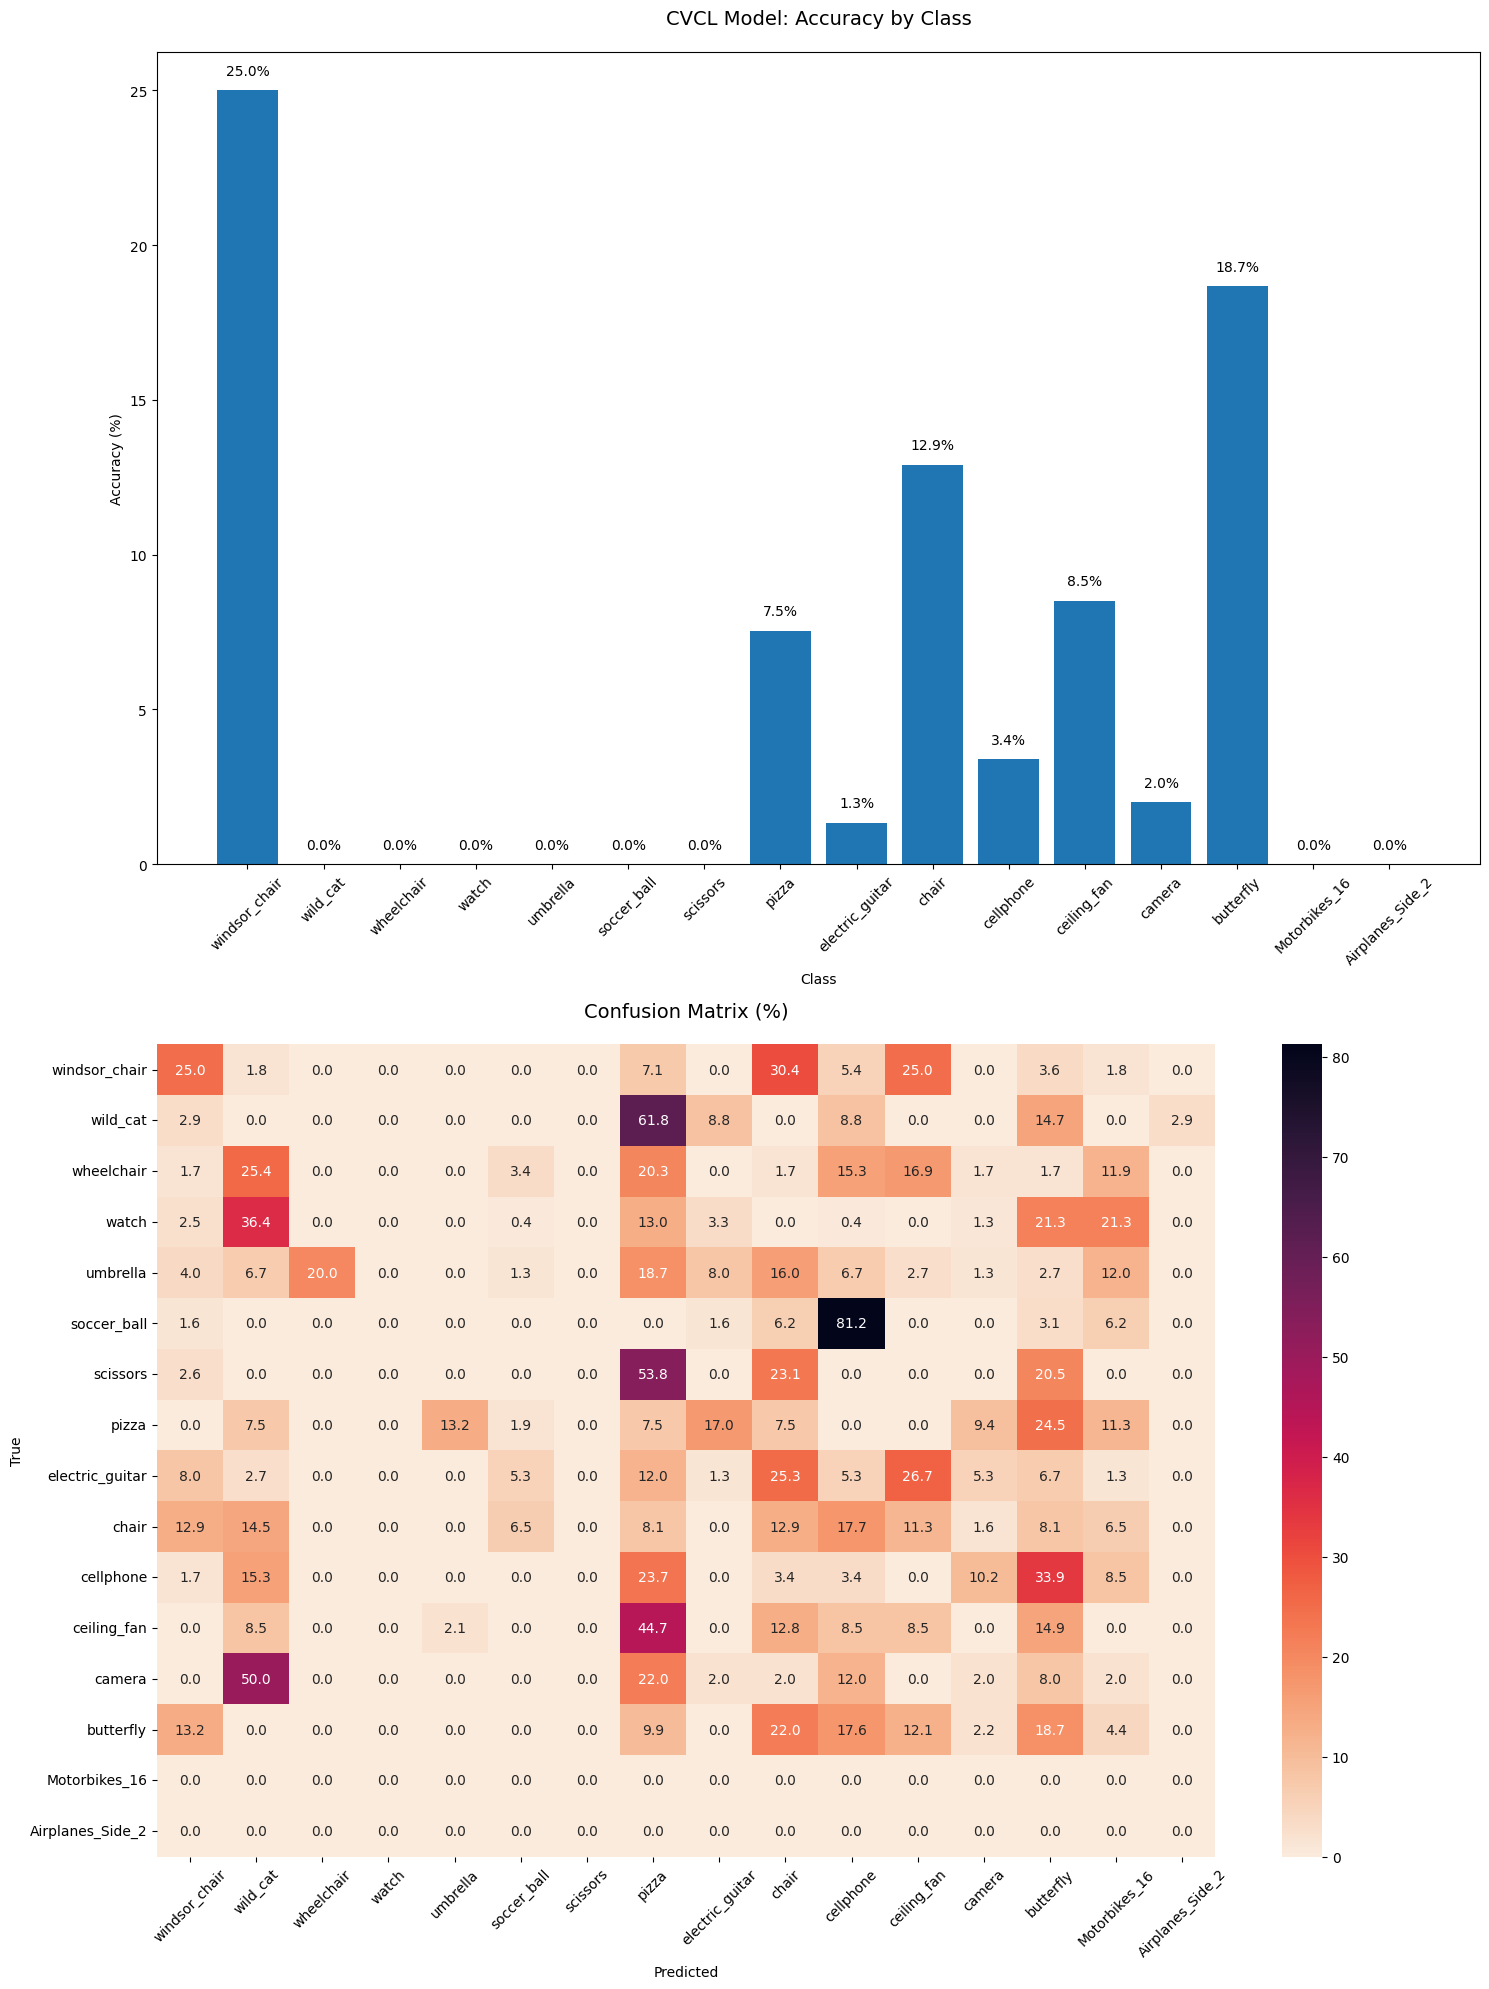

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_accuracy_and_confusion(class_stats, class_predictions):
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    # 创建图形
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

    # 1. 准确率条形图
    accuracies = []
    class_names = []
    for class_name in TARGET_CLASSES:
        stats = class_stats[class_name]
        if stats['total'] > 0:
            accuracy = (stats['correct'] / stats['total'] * 100)
        else:
            accuracy = 0.0
        accuracies.append(accuracy)
        class_names.append(class_name)

    ax1.bar(class_names, accuracies, color='#2076B3')
    ax1.set_title('CVCL Model: Accuracy by Class', fontsize=14, pad=20)
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Accuracy (%)')
    ax1.tick_params(axis='x', rotation=45)

    # 在柱子上添加准确率标签
    for i, v in enumerate(accuracies):
        ax1.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

    # 2. 混淆矩阵热力图
    confusion_matrix = np.zeros((len(TARGET_CLASSES), len(TARGET_CLASSES)))
    for true_class, pred_dict in class_predictions.items():
        true_idx = TARGET_CLASSES.index(true_class)
        total = sum(pred_dict.values())
        for pred_class, count in pred_dict.items():
            pred_idx = TARGET_CLASSES.index(pred_class)
            confusion_matrix[true_idx, pred_idx] = (count / total) * 100 if total > 0 else 0

    sns.heatmap(confusion_matrix,
                annot=True,
                fmt='.1f',
                xticklabels=TARGET_CLASSES,
                yticklabels=TARGET_CLASSES,
                ax=ax2,
                cmap='rocket_r')

    ax2.set_title('Confusion Matrix (%)', fontsize=14, pad=20)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# 在评估模型时收集预测结果
class_predictions = defaultdict(lambda: defaultdict(int))

def evaluate_dataset_with_predictions():
    class_stats = defaultdict(lambda: {'correct': 0, 'total': 0})
    total_correct = 0
    total_samples = 0

    for class_name in TARGET_CLASSES:
        class_dir = os.path.join(pic_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        for img_name in os.listdir(class_dir):
            if not img_name.endswith('.jpg'):
                continue

            img_path = os.path.join(class_dir, img_name)
            try:
                image = Image.open(img_path).convert('RGB')
                image = transform(image).unsqueeze(0)

                with torch.no_grad():
                    output = model(image)
                    _, predicted = torch.max(output.data, 1)

                class_stats[class_name]['total'] += 1
                total_samples += 1

                predicted_class = TARGET_CLASSES[predicted.item()]
                class_predictions[class_name][predicted_class] += 1

                if predicted.item() == class_to_idx[class_name]:
                    class_stats[class_name]['correct'] += 1
                    total_correct += 1

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                continue

    return class_stats, class_predictions, total_correct/total_samples if total_samples > 0 else 0

# 执行评估并绘图
class_stats, class_predictions, overall_accuracy = evaluate_dataset_with_predictions()
plot_accuracy_and_confusion(class_stats, class_predictions)